In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import linregress
from scipy.spatial.distance import cdist


from utils import geometry
from utils import fileio

In [2]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')

def plot_cell_centres(cell_centres):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],'k',marker ='o',markersize=1)
        
def plot_cell_id(cell_centres):
    for i in range(len(cell_centres)):
        plt.text(cell_centres[i][0], cell_centres[i][1], str(i),fontsize= 7,color='w', horizontalalignment='center', verticalalignment='center')

def plot_alignment_axis(cell_centres,alignment_axis):
    for i in range(len(cell_centres)):
            plt.quiver(cell_centres[i,0],cell_centres[i,1],np.cos(alignment_axis)[i],np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
            plt.quiver(cell_centres[i,0],cell_centres[i,1],-np.cos(alignment_axis)[i],-np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)



def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

def plot_binary_polys(C, R, cell_centres, plot_var, threshold):
    N_c=np.shape(C)[0]
    patches = []
    patchesLow = []
    patchesHigh = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)
        
        if plot_var[i] < threshold:
            polygonLow = polygon
            patchesLow.append(polygonLow)
        else:
            polygonHigh = polygon
            patchesHigh.append(polygonHigh)


    ### For binary effective pressure
    p_low = PatchCollection(patchesLow,alpha = 0.5)
    p_high = PatchCollection(patchesHigh,alpha = 0.7)
   
    return p_low, p_high


In [3]:
def plot_cmap(plot_variable, cmap, save_dir, stretch, frame,title, c_label, A,B,C,R, cc,cmin,cmax):
    #plot_variable=cell_circ_0 ###Set variable to plot

    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

    ## For colormap of continuous data
    polys=plot_polys(C, R, cc)
    polys.set_facecolor('black')
    ax.add_collection(polys) 

    polys=plot_polys(C, R, cc)
    #polys.set_facecolor('black')
    polys.set_array(plot_variable)
    polys.set_cmap(cmap) ###set polygon colourmap here
    polys.set_clim(cmin, cmax)
    ax.add_collection(polys) 
    cbar = fig.colorbar(polys, ax=ax, extend='both')
    cbar.ax.set_ylabel(c_label, rotation=90) ###set colorbar label




    ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    plot_edges(A, R)

    plot_cell_id(cc)

    ax.set_title(title) ###change title
    plt.xlim(-350, 250)
    plt.ylim(-300, 300)
    plt.gca().set_aspect('equal')
    plt.tight_layout()

    ##uncomment to save
    plt.savefig(save_dir+'/'+title+'.png', dpi=300)

In [1]:
pixel_size=1024
micron_size=554.11
input_dir=os.getcwd()+'/Input/'
mat_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126\\Matrices/'
data_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126\\Data/'
plot_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126\\Plots/'
files_u=sorted(glob(data_dir+'20230126_2_uf_0p5_fr*_cell_data_all_Gamma_0.172_Lambda_-0.259.csv'))
files_s=sorted(glob(data_dir+'20230126_2_uf_8p6_fr*_cell_data_all_Gamma_0.172_Lambda_-0.259.csv'))
df=pd.read_csv(files_u[0])
df['frame']=1
df['time']=0
df['area_norm']=df.cell_area_microns.div(df[df.time==0].cell_area_microns, axis=0)
df['perimeter_norm']=df.cell_perimeter_microns.div(df[df.time==0].cell_perimeter_microns, axis=0)
df['shear_strain']=(df.cell_perimeter_microns/df.cell_area_microns) * df.cell_zeta
df['area_change_norm']=(df.cell_area_microns-df[df.time==0].cell_area_microns).div(df[df.time==0].cell_area_microns, axis=0)
df['area_change']=(df.cell_area_microns-df[df.time==0].cell_area_microns)
df['angle_horizontal']=abs(np.where(df[df.time==0].major_shape_axis_alignment_rads<np.pi/2,df[df.time==0].major_shape_axis_alignment_rads, df[df.time==0].major_shape_axis_alignment_rads-np.pi))
df['circ_area']=4*np.pi*df.cell_area_microns/(df.cell_perimeter_microns*df.cell_perimeter_microns)
for f in files_s:
    data_s=pd.read_csv(f)
    data_s['frame']=int(f.split('\\')[-1].split('_')[4][2:])
    data_s['time']=(data_s['frame'][0]+4)*60
    data_s['area_norm']=data_s.cell_area_microns.div(df[df.time==0].cell_area_microns, axis=0)
    data_s['perimeter_norm']=data_s.cell_perimeter_microns.div(df[df.time==0].cell_perimeter_microns, axis=0)
    data_s['shear_strain']=(data_s.cell_perimeter_microns/data_s.cell_area_microns) * data_s.cell_zeta
    data_s['area_change']=(data_s.cell_area_microns-df[df.time==0].cell_area_microns)
    data_s['area_change_norm']=(data_s.cell_area_microns-df[df.time==0].cell_area_microns).div(df[df.time==0].cell_area_microns, axis=0)
    data_s['angle_horizontal']=abs(np.where(data_s.major_shape_axis_alignment_rads<np.pi/2,data_s.major_shape_axis_alignment_rads, data_s.major_shape_axis_alignment_rads-np.pi))
    data_s['circ_area']=4*np.pi*data_s.cell_area_microns/(data_s.cell_perimeter_microns*data_s.cell_perimeter_microns)
    df=pd.concat([df, data_s], ignore_index=True)

df.to_csv(data_dir+'20230126_2_collated.csv')

c_files=sorted(glob(input_dir+'20230126_2_*_uf_*_*fr*_*_conf.csv'))
c_files_n=np.zeros_like(c_files)
c_files_n[0]=c_files[0]
c_files_n[1]=c_files[3]
c_files_n[2]=c_files[-1]
c_files_n[3:5]=c_files[1:3]
c_files_n[5:]=c_files[4:-1]

R_all=[]
A_all=[]
B_all=[]
C_all=[]
for f in c_files_n:
    print(f)

    #read in conf file
    edges_name,t_min, pixel_size, micron_size = fileio.read_conf(f)
    exp_id=edges_name.split('_')[0]+'_'+edges_name.split('_')[1]+'_'+edges_name.split('_')[4]+'_'+edges_name.split('_')[5]+'_'+edges_name.split('_')[7]
    t=t_min*60.0
    stretch_type=edges_name.split('_')[4][-1]
    stretch_len=edges_name.split('_')[5]
    frame=edges_name.split('_')[7][2:]
    print(exp_id)

    A  = np.loadtxt(glob(mat_dir+'/*_*'+stretch_len+'_*'+frame+'_*Matrix_A.txt')[0]) # Incidence matrix. Rows => edges; columns => vertices.
    B  = np.loadtxt(glob(mat_dir+'/*_*'+stretch_len+'_*'+frame+'_*Matrix_B.txt')[0]) # Incidence matrix. Rows => cells; columns => edges. Values +/-1 for orientation
    C  = np.loadtxt(glob(mat_dir+'/*_*'+stretch_len+'_*'+frame+'_*Matrix_C.txt')[0]) # Incidence matrix. Rows => cells; columns => vertices. 
    R  = np.loadtxt(glob(mat_dir+'/*_*'+stretch_len+'_*'+frame+'_*Matrix_R.txt')[0])*(micron_size/pixel_size)

    A_all.append(A)
    B_all.append(B)
    C_all.append(C)
    R_all.append(R)


NameError: name 'os' is not defined

In [22]:
c_files=sorted(glob(input_dir+'20230126_2_*_uf_*_*fr*_*_conf.csv'))
c_files_n=np.zeros_like(c_files)
c_files_n[0]=c_files[0]
c_files_n[1]=c_files[3]
c_files_n[2]=c_files[-1]
c_files_n[3:5]=c_files[1:3]
c_files_n[5:]=c_files[4:-1]

c_files[0:3]
c_files[4:-1]
c_files_n

array(['c:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis/Input\\20230126_2_IN_BFPCAAX-CheHis_uf_0p5_MP_fr1_trace_conf.csv',
       'c:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis/Input\\20230126_2_IN_BFPCAAX-CheHis_uf_8p6_MP_fr1_trace_conf.csv',
       'c:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis/Input\\20230126_2_IN_BFPCAAX-CheHis_uf_8p6_MP_fr6_trace_conf.csv',
       'c:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis/Input\\20230126_2_IN_BFPCAAX-CheHis_uf_8p6_MP_fr11_trace_conf.csv',
       'c:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis/Input\\20230126_2_IN_BFPCAAX-CheHis_uf_8p6_MP_fr16_trace_conf.csv',
       'c:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Code\\tissue_image_analysis\\tissue_image_analysis/Input\\20230126_2_IN_BFPCAAX-CheHis_uf_8p6_MP_fr21_

In [790]:
df.columns

Index(['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'cell_perimeter_nd', 'cell_area_nd', 'cell_P_eff_nd', 'shape_parameter',
       'circularity', 'cell_edge_count', 'cell_shear', 'cell_zeta',
       'major_shape_axis_alignment_rads', 'major_stress_axis_alignment_rads',
       'frame', 'time', 'area_norm', 'perimeter_norm'],
      dtype='object')

In [97]:
df[df.time==0].cell_area_microns

0      144.503784
1      147.139111
2      548.294499
3      301.452169
4      276.709374
          ...    
267    815.487413
268    892.497535
269    715.052159
270    797.625750
271    827.785607
Name: cell_area_microns, Length: 272, dtype: float64

In [69]:
areas_time=df.pivot(index='cell_id', columns='time', values='cell_area_microns')
area_norm=areas_time.div(areas_time[0], axis=0)

time     0         300       600       900       1200      1500      1800  \
cell_id                                                                     
0.0       1.0  0.559271  0.765957  0.851064  1.352584  1.013171  1.652482   
1.0       1.0  1.205970  1.068657  1.232836  1.351244  1.267662  1.770149   
2.0       1.0  1.056075  1.236315  1.050467  1.314286  1.257677  1.076101   
3.0       1.0  1.261292  1.168528  1.327829  1.313259  1.234094  1.104420   
4.0       1.0  0.936508  0.884127  1.274603  1.069841  1.047619  1.178836   
...       ...       ...       ...       ...       ...       ...       ...   
267.0     1.0  1.090485  1.027469  1.081688  1.157989  1.145781  1.145601   
268.0     1.0  1.114829  1.186188  1.113353  1.195538  1.137795  1.142388   
269.0     1.0  1.140459  1.083948  1.029279  1.089681  1.095618  1.054873   
270.0     1.0  1.135279  1.178414  1.240455  1.276065  1.320668  1.263950   
271.0     1.0  1.140608  1.110541  1.184117  0.996993  1.092855  1.158118   

time         2100      2400      2700      3000      3300      3600  
cell_id                                                              
0.0      1.967579  1.733536  1.600811  1.479230  1.815603  2.031408  
1.0      1.795025  1.729353  1.646766  1.723383  2.089552  1.763184  
2.0      1.163151  1.122296  0.934846  0.757810  1.079840  1.089720  
3.0      0.974745  1.049053  1.029140  1.235551  1.182613  0.996600  
4.0      1.121693  1.092593  1.296825  1.022222  1.135979  1.079365  
...           ...       ...       ...       ...       ...       ...  
267.0    1.198743  1.197127  1.249013  1.205206  1.213824  1.246499  
268.0    1.125000  1.144521  1.063812  1.054626  1.066765  1.173885  
269.0    1.013104  1.152334  1.025594  1.108313  1.096028  1.031122  
270.0    1.197504  1.148678  1.136747  1.255140  1.260095  1.266336  
271.0    1.163601  1.172267  1.227626  1.151928  1.211178  1.238415  

[272 rows x 13 columns]

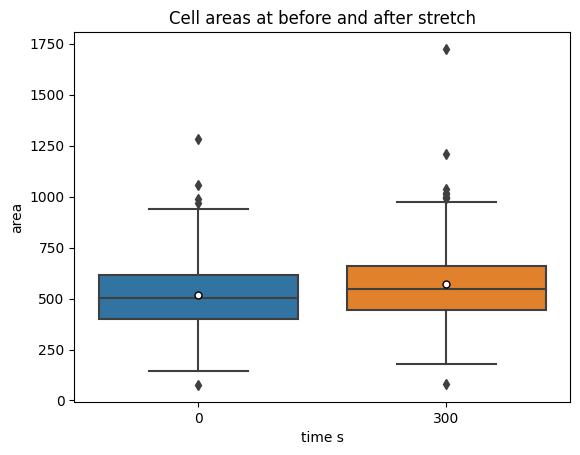

<AxesSubplot: xlabel='time', ylabel='circularity'>

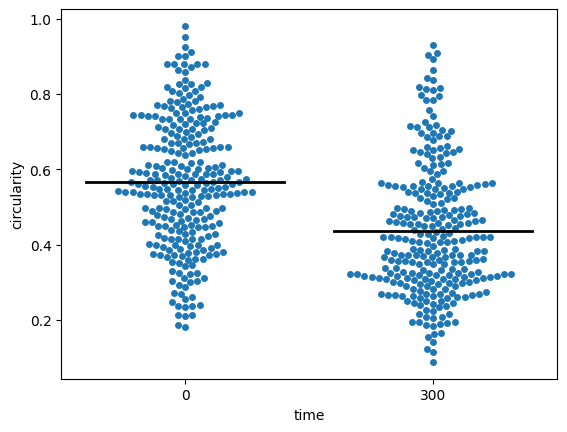

In [678]:
sns.boxplot(data=df[(df.time ==0) | (df.time==300)], x='time',y='cell_area_microns', showmeans=True,            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
plt.xlabel('time s')
plt.ylabel('area')
plt.title('Cell areas at before and after stretch')
plt.show()
sns.swarmplot(data=df[(df.time ==0) | (df.time==300)], x='time',y='circularity')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x='time',y='circularity',
            data=df[(df.time ==0) | (df.time==300)],
            showfliers=False,
            showbox=False,
            showcaps=False)

<AxesSubplot: xlabel='time', ylabel='major_shape_axis_alignment_rads'>

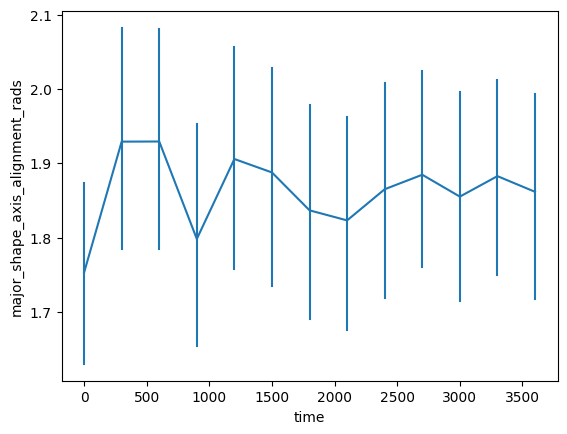

In [975]:
sns.lineplot(data=df, x="time", y="major_shape_axis_alignment_rads", err_style='bars', errorbar='ci')
#plt.ylabel("Mean Angle with horizontal")
#plt.xlabel("time, s")
#plt.title("Angle of long axis with horizontal")
#plt.ylim(0, 45/180*np.pi)
#plt.yticks(np.linspace(0, 45/180*np.pi, 3),[0,'$\\frac{\pi}{8}$','$\\frac{\pi}{4}$'])

#plt.savefig(plot_dir+'/angle_time_ci.png', dpi=300, bbox_inches='tight')



In [918]:
0.7/np.pi*180

40.10704565915763

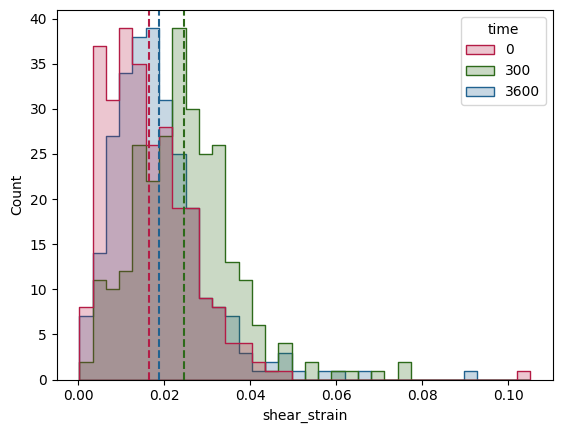

In [910]:
sns.histplot(data=df[(df.time ==0) | (df.time==300)| (df.time==3600)], hue='time',x='shear_strain', element="step", palette=sns.husl_palette(3,l=.4))
plt.axvline(np.mean(df[df.time ==0].shear_strain), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
plt.axvline(np.mean(df[df.time ==300].shear_strain), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
plt.axvline(np.mean(df[df.time ==3600].shear_strain), c=sns.husl_palette(3,l=.4)[2], linestyle='--')
plt.xlabel('shear_strain')
plt.savefig(plot_dir+'/shear_strain.png', dpi=300)

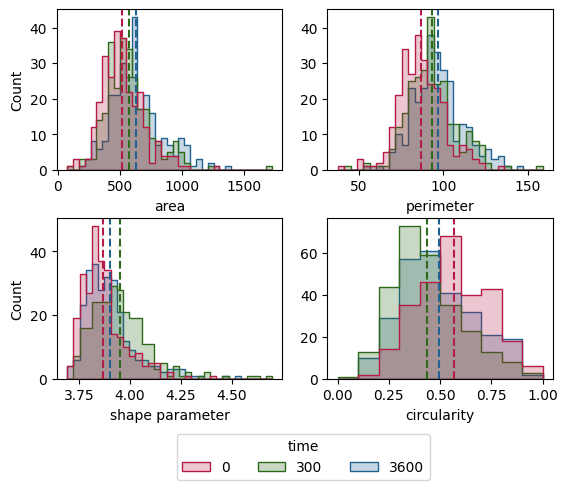

In [907]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=df[(df.time ==0) | (df.time==300)| (df.time==3600)], hue='time',x='cell_area_microns', element="step", palette=sns.husl_palette(3,l=.4), ax=ax[0,0])
ax[0,0].axvline(np.mean(df[df.time ==0].cell_area_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,0].axvline(np.mean(df[df.time ==300].cell_area_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,0].axvline(np.mean(df[df.time ==3600].cell_area_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

sns.histplot(data=df[(df.time ==0) | (df.time==300)| (df.time==3600)], hue='time',x='cell_perimeter_microns', element="step",legend=False, palette=sns.husl_palette(3,l=.4), ax=ax[0,1])
ax[0,1].axvline(np.mean(df[df.time ==0].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[0,1].axvline(np.mean(df[df.time ==300].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,1].axvline(np.mean(df[df.time ==3600].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

sns.histplot(data=df[(df.time ==0) | (df.time==300)| (df.time==3600)], hue='time',x='circularity', element="step", legend=False, palette=sns.husl_palette(3,l=.4), ax=ax[1,1], binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(df[df.time ==0].circularity), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,1].axvline(np.mean(df[df.time ==300].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,1].axvline(np.mean(df[df.time ==3600].circularity), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

sns.histplot(data=df[(df.time ==0) | (df.time==300)| (df.time==3600)], hue='time',x='shape_parameter', element="step", legend=False, palette=sns.husl_palette(3,l=.4), ax=ax[1,0])
ax[1,0].axvline(np.mean(df[df.time ==0].shape_parameter), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,0].axvline(np.mean(df[df.time ==300].shape_parameter), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,0].axvline(np.mean(df[df.time ==3600].shape_parameter), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -1.6), frameon=True, ncol=3)
plt.savefig(plot_dir+'/shape_hists_all.png', dpi=300, bbox_inches='tight')

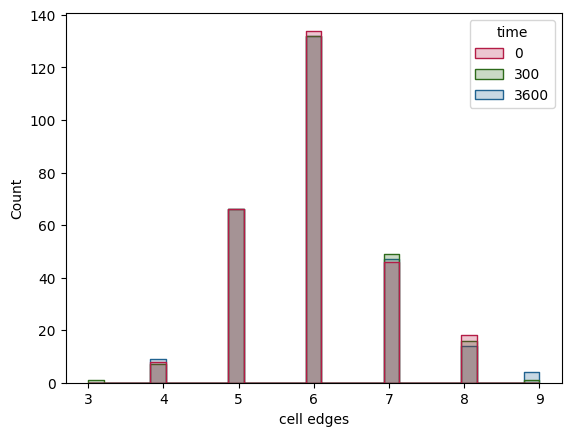

In [6]:
sns.histplot(data=df[(df.time ==0) | (df.time==300)| (df.time==3600)], hue='time',x='cell_edge_count', element="step", palette=sns.husl_palette(3,l=.4))

plt.xlabel('cell edges')
plt.savefig(plot_dir+'/cec_hist.png', dpi=300)

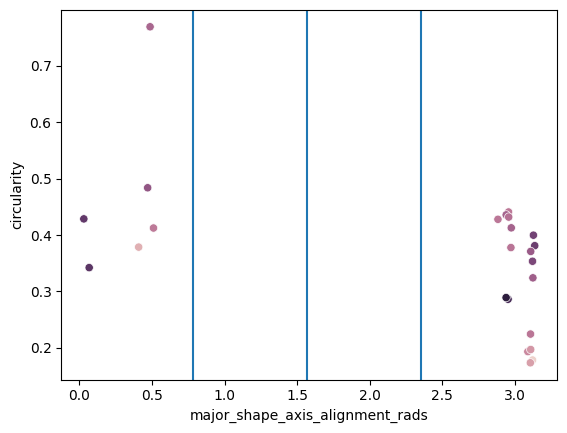

In [17]:
sns.scatterplot(data=df[df.cell_edge_count==9], x='major_shape_axis_alignment_rads', hue='cell_area_microns', y='circularity', legend=False)
plt.axvline(np.pi/4)
plt.axvline(np.pi/2)
plt.axvline(3*np.pi/4)

ValueError: <seaborn.axisgrid.FacetGrid object at 0x0000026551292740> has no legend attached.

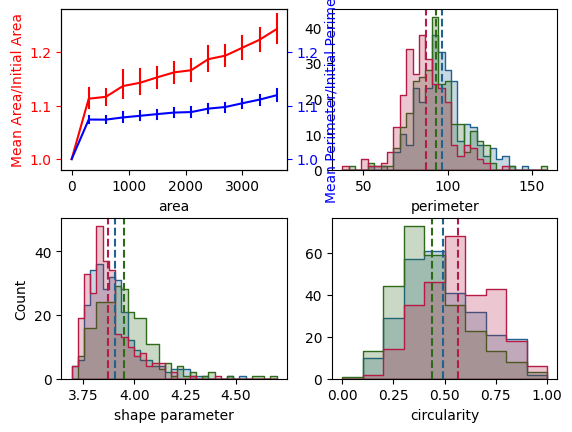

In [977]:
fig, ax=plt.subplots(2,2)
ax2 = ax[0,0].twinx()
sns.lineplot(data=df, x="time", y="area_norm", err_style='bars', errorbar='ci', ax=ax[0,0], c='red')
sns.lineplot(data=df, x="time", y="perimeter_norm", err_style='bars', errorbar='ci', ax=ax2, c='blue')
ax[0,0].tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', colors='blue')
ax[0,0].set_ylim(0.99,1.28)
ax2.set_ylim(0.99,1.28)
ax2.set(ylabel="Mean Perimeter/Initial Perimeter")
ax[0,0].set(ylabel="Mean Area/Initial Area")
ax[0,0].yaxis.label.set_color('red')
ax2.yaxis.label.set_color('blue')

#plt.ylabel("Mean Perimeter/Initial Perimeter")
ax[0,0].set_xlabel("time, s")
#plt.title("Normalised Cell Area and Perimeter")


sns.lineplot(data=df, x='time', y='circularity' ax=ax[1,0])
sns.lineplot(data=df, x='time', y='shear_strain' ax=ax[1,1])


sns.histplot(data=df[(df.time ==0) | (df.time==300)| (df.time==3600)], hue='time',x='circularity', element="step", legend=False, palette=sns.husl_palette(3,l=.4), ax=ax[1,1], binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(df[df.time ==0].circularity), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,1].axvline(np.mean(df[df.time ==300].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,1].axvline(np.mean(df[df.time ==3600].circularity), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

sns.histplot(data=df[(df.time ==0) | (df.time==300)| (df.time==3600)], hue='time',x='shape_parameter', element="step", legend=False, palette=sns.husl_palette(3,l=.4), ax=ax[1,0])
ax[1,0].axvline(np.mean(df[df.time ==0].shape_parameter), c=sns.husl_palette(3,l=.4)[0], linestyle='--')
ax[1,0].axvline(np.mean(df[df.time ==300].shape_parameter), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,0].axvline(np.mean(df[df.time ==3600].shape_parameter), c=sns.husl_palette(3,l=.4)[2], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -1.6), frameon=True, ncol=3)


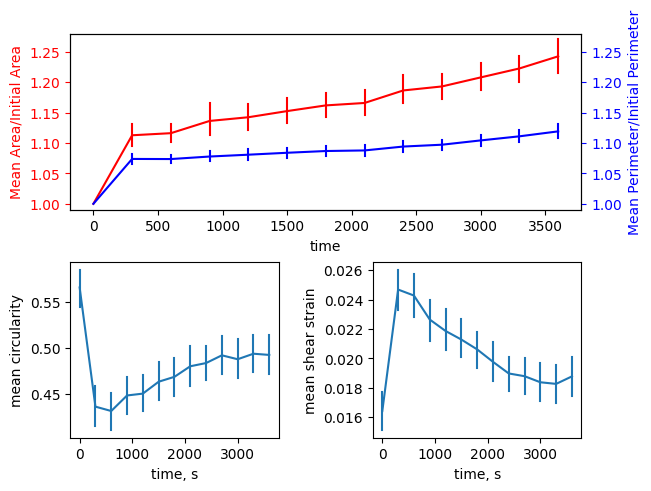

In [988]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(layout="constrained")

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax11 = ax1.twinx()
sns.lineplot(data=df, x="time", y="area_norm", err_style='bars', errorbar='ci', ax=ax1, c='red')
sns.lineplot(data=df, x="time", y="perimeter_norm", err_style='bars', errorbar='ci', ax=ax11, c='blue')
ax1.tick_params(axis='y', colors='red')
ax11.tick_params(axis='y', colors='blue')
ax1.set_ylim(0.99,1.28)
ax11.set_ylim(0.99,1.28)
ax11.set(ylabel="Mean Perimeter/Initial Perimeter")
ax1.set(ylabel="Mean Area/Initial Area")
ax1.yaxis.label.set_color('red')
ax11.yaxis.label.set_color('blue')

sns.lineplot(data=df, x="time", y="circularity", err_style='bars', errorbar='ci',ax=ax2)
sns.lineplot(data=df, x="time", y="shear_strain", err_style='bars', errorbar='ci', ax=ax3)
ax2.set_xlabel("time, s")
ax2.set_ylabel("mean circularity")
ax3.set_xlabel("time, s")
ax3.set_ylabel("mean shear strain")


fig.suptitle(" ")


plt.savefig(plot_dir+'/shape_line_all.png', dpi=300, bbox_inches='tight')

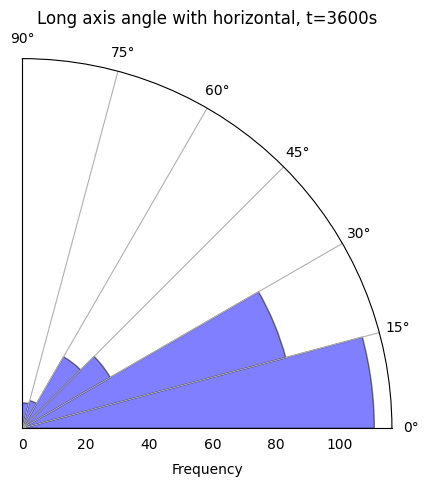

In [940]:
    bins = np.linspace(0.0, 90/180 *np.pi,7)

    angle=rotate_angle_0

    n, _, _ = plt.hist(df[df.time==3600].angle_horizontal,range=[0,np.pi/2], bins=6)

    plt.clf()
    width = np.pi/2 /6
    ax = plt.subplot(1, 1, 1, projection='polar')
    bars = ax.bar(bins[:6], n, width=width, bottom=0, align='edge',color='blue', edgecolor='k')
    for bar in bars:
        bar.set_alpha(0.5)
        
    ax.set_xticks(bins)
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    ax.yaxis.grid(False)
    ax.set_xlabel('Frequency')
    ax.set_title('Long axis angle with horizontal, t=3600s')
    ax.xaxis.labelpad=20
    plt.savefig(plot_dir+'/angle_3600.png', dpi=300, bbox_inches='tight')

In [697]:
from scipy.stats import mannwhitneyu, ttest_ind, ttest_rel

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_60948\1633971783.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar=ax.figure.colorbar(sm)


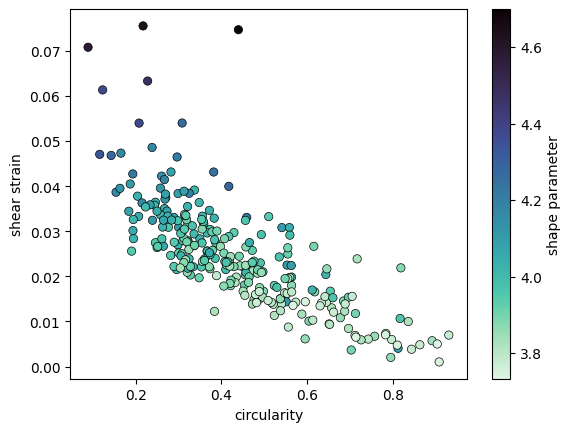

In [901]:
ax=sns.scatterplot(data=df[df.time==300],x='circularity',y='shear_strain', hue='shape_parameter', palette='mako_r', edgecolor='black')
#plt.clim(3.7, 4.7)
norm = plt.Normalize(df[df.time==300].shape_parameter.min(), df[df.time==300].shape_parameter.max())
sm = plt.cm.ScalarMappable(cmap=sns.color_palette("mako_r", as_cmap=True), norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
cbar=ax.figure.colorbar(sm)
plt.ylabel('shear strain')
cbar.ax.set_ylabel('shape parameter')
plt.savefig(plot_dir+'/circ_shear_shape.png', dpi=300, bbox_inches='tight')

In [690]:
mannwhitneyu(df[df.time==0].cell_area_microns,df[df.time==300].cell_area_microns)
ttest_ind(df[df.time==0].cell_area_microns,df[df.time==300].cell_area_microns)
#ttest_rel(df[df.time==0].cell_area_microns,df[df.time==300].cell_area_microns)

TtestResult(statistic=-14.416694540214609, pvalue=2.320803371957288e-35, df=271)

In [699]:
mannwhitneyu(df[df.time==0].circularity,df[df.time==300].circularity)
circ_tt=ttest_ind(df[df.time==0].circularity,df[df.time==300].circularity)
ttest_ind(df[df.time==0].circularity,df[df.time==300].circularity, equal_var=False)

Ttest_indResult(statistic=8.850359705909915, pvalue=1.2361745228721899e-17)

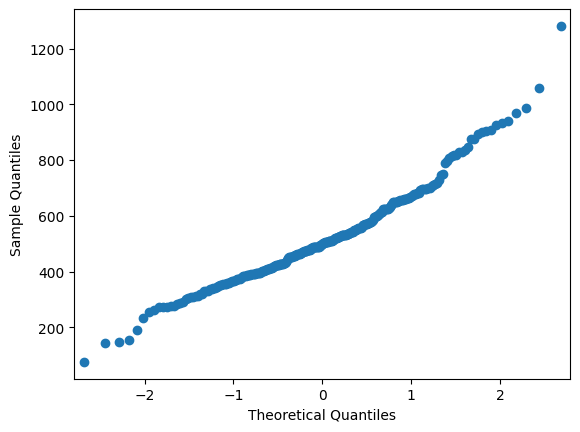

In [683]:
sm.qqplot(df[df.time==0].cell_area_microns)
plt.show()

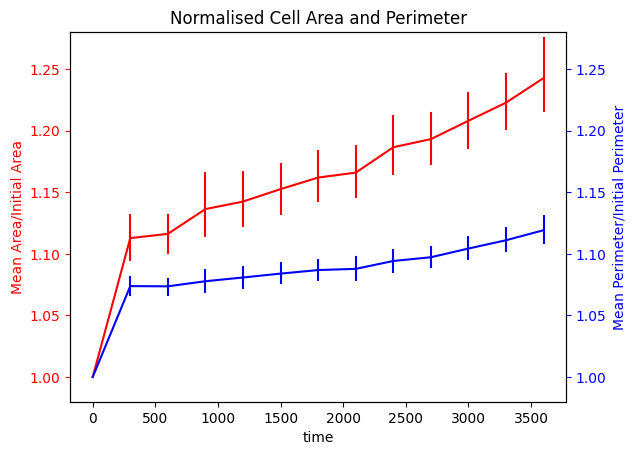

In [673]:
ax1 = plt.subplot()
ax2 = ax1.twinx()
sns.lineplot(data=df, x="time", y="area_norm", err_style='bars', errorbar='ci', ax=ax1, c='red')
sns.lineplot(data=df, x="time", y="perimeter_norm", err_style='bars', errorbar='ci', ax=ax2, c='blue')
ax1.tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', colors='blue')
ax1.set_ylim(0.98,1.28)
ax2.set_ylim(0.98,1.28)
ax2.set(ylabel="Mean Perimeter/Initial Perimeter")
ax1.set(ylabel="Mean Area/Initial Area")
ax1.yaxis.label.set_color('red')
ax2.yaxis.label.set_color('blue')

#plt.ylabel("Mean Perimeter/Initial Perimeter")
plt.xlabel("time, s")
plt.title("Normalised Cell Area and Perimeter")
plt.savefig(plot_dir+'/normalised_perimeter_area_time_ci.png', dpi=300)

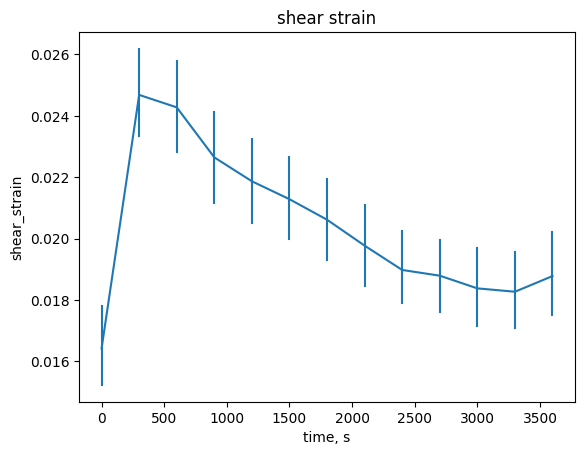

In [56]:
sns.lineplot(data=df, x="time", y="shear_strain", err_style='bars', errorbar='ci')
plt.xlabel("time, s")
plt.title("shear strain")
plt.savefig(plot_dir+'/shear_strain_time_ci.png', dpi=300)

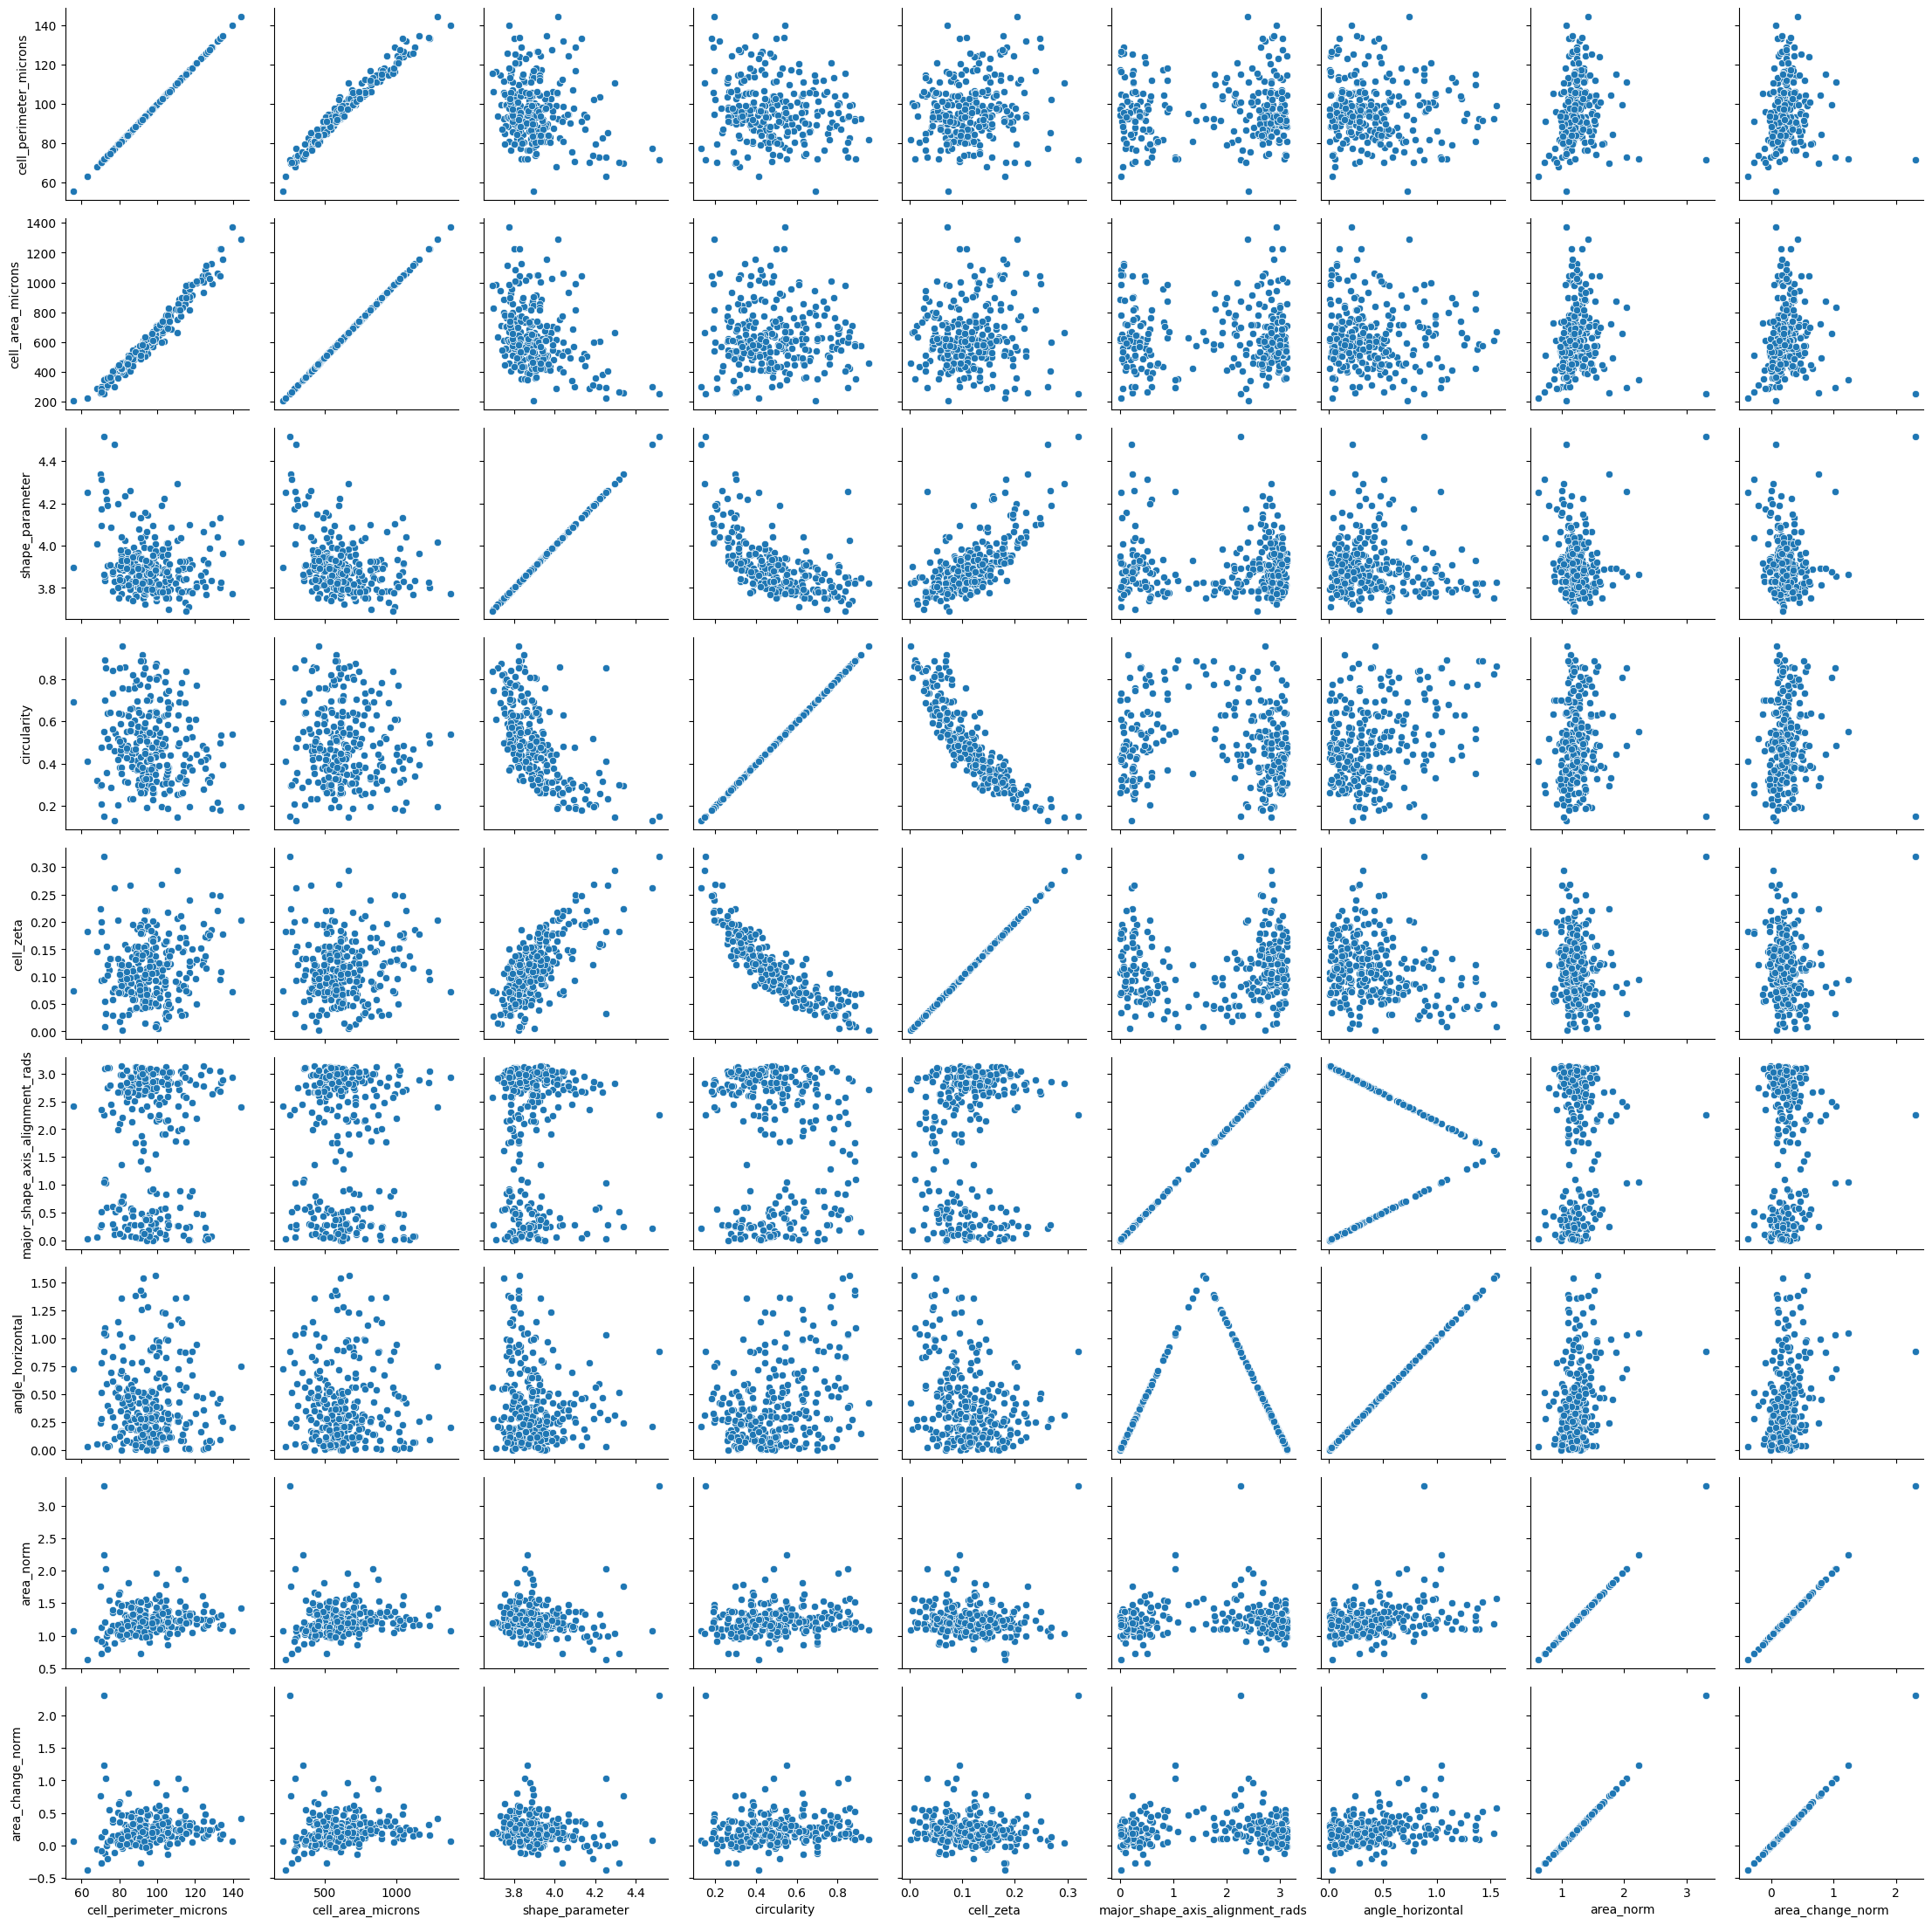

In [76]:
df_pp=df[df.time==3600][[ 'cell_perimeter_microns', 'cell_area_microns', 'shape_parameter',
       'circularity',  'cell_zeta',
       'major_shape_axis_alignment_rads', 'angle_horizontal', 'area_norm', 'area_change_norm']]
g = sns.PairGrid(df_pp)
g.map(sns.scatterplot)

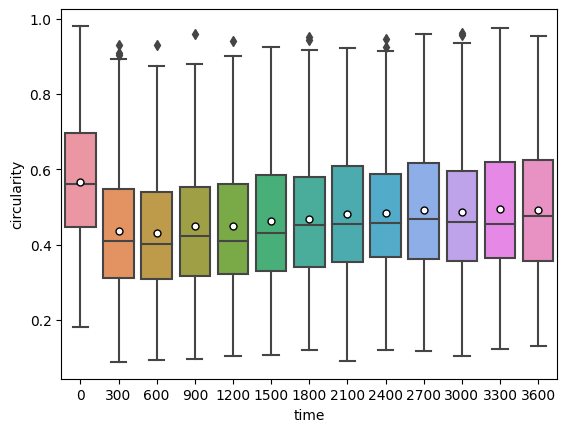

<AxesSubplot: xlabel='time', ylabel='circularity'>

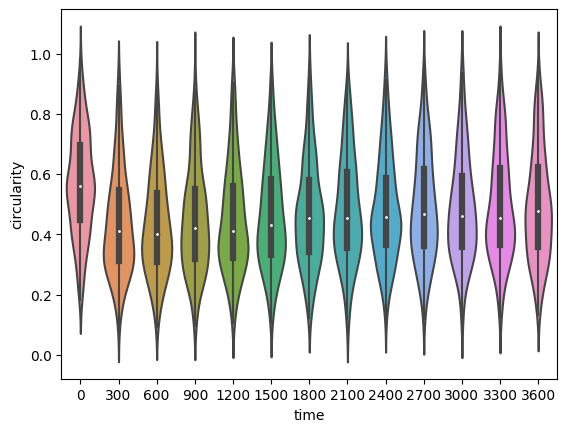

In [140]:
sns.boxplot(data=df, x='time',y='circularity', showmeans=True,            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"})
plt.show()
sns.violinplot(data=df, x='time',y='circularity', showmeans=True,            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"})

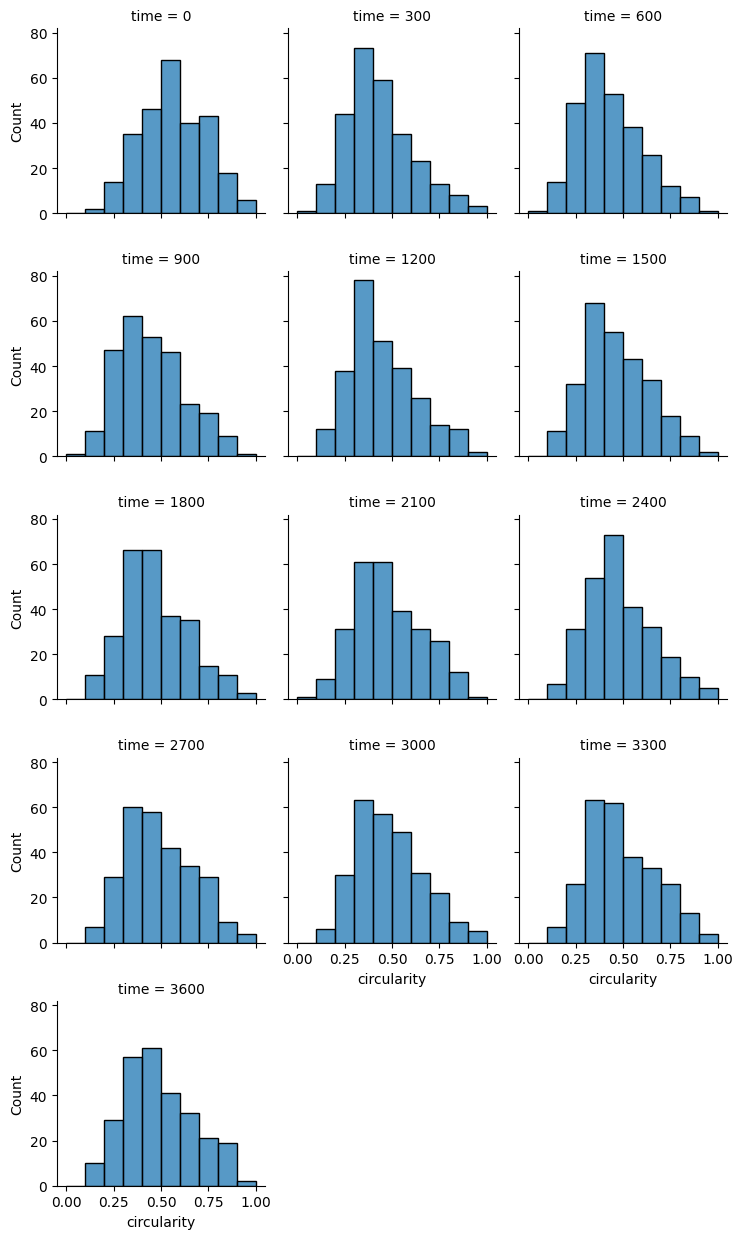

In [131]:
g = sns.FacetGrid(df, col="time", height=2.5, col_wrap=3)
g.map(sns.histplot, "circularity", stat='count', binrange=[0,1], binwidth=0.1)

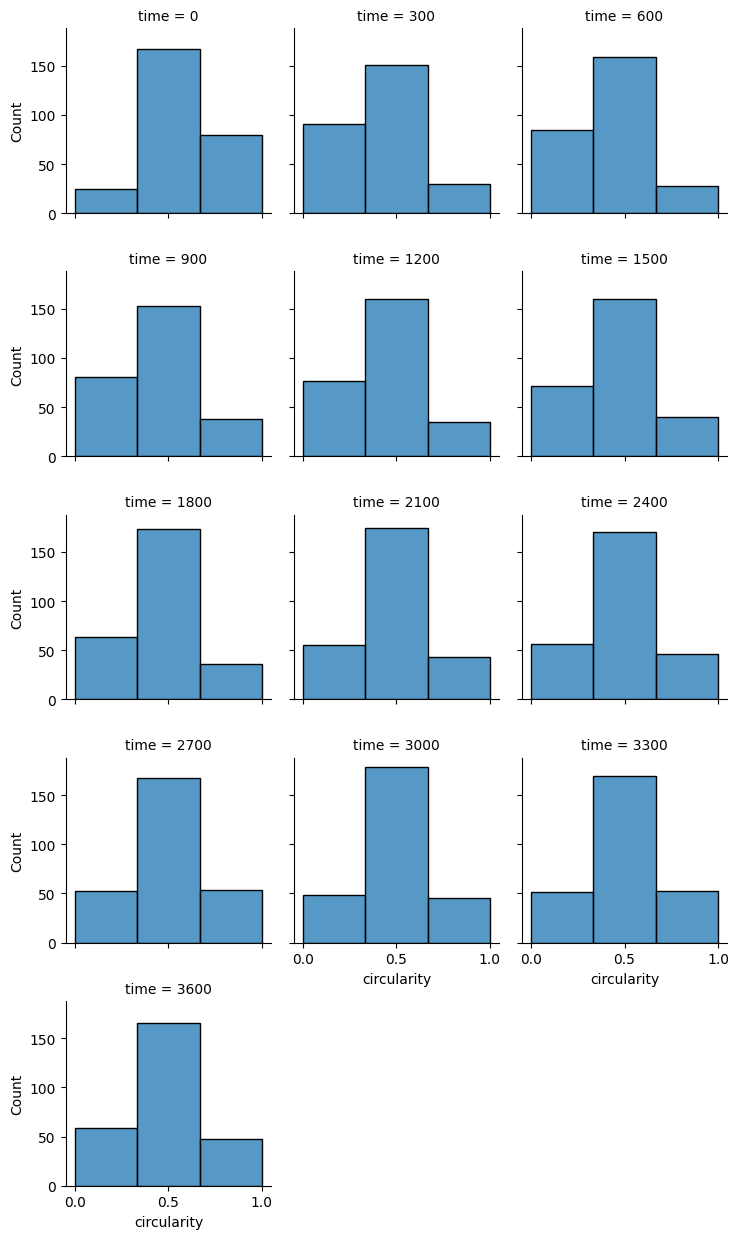

In [974]:
g = sns.FacetGrid(df, col="time", height=2.5, col_wrap=3)
g.map(sns.histplot, "circularity", stat='count', binrange=[0,1], bins=3)

<AxesSubplot: xlabel='time', ylabel='cell_id'>

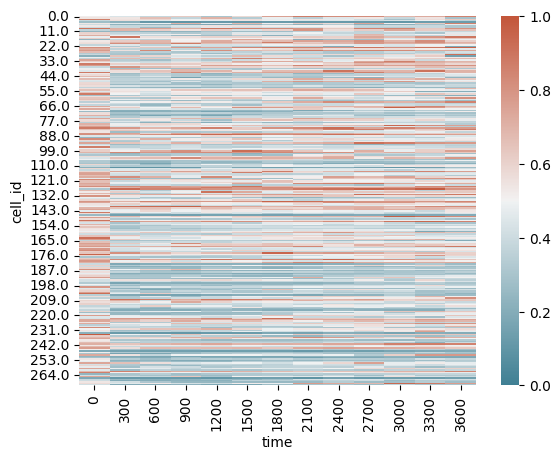

In [154]:
sns.heatmap(df.pivot(index='cell_id', columns='time', values='circularity'), vmin=0, vmax=1, cmap=sns.diverging_palette(220, 20, as_cmap=True))

<AxesSubplot: xlabel='time', ylabel='shape_parameter'>

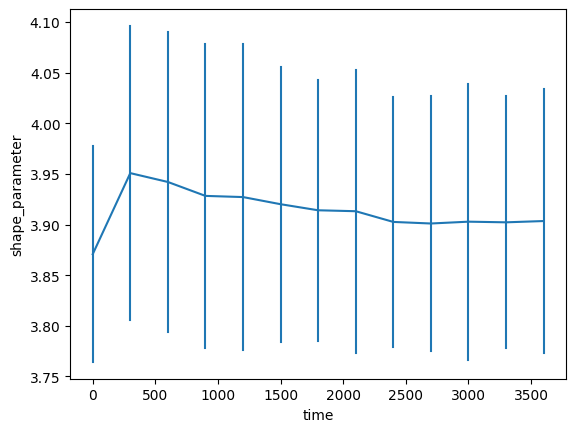

In [139]:
sns.lineplot(data=df, x="time", y="shape_parameter", err_style='bars', errorbar='sd')

<AxesSubplot: xlabel='time', ylabel='cell_id'>

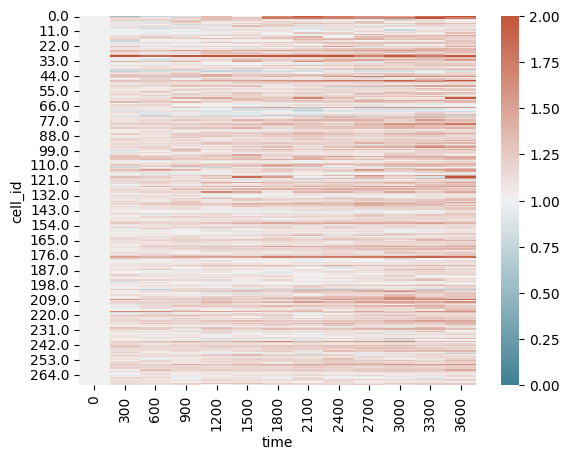

In [152]:
vmax = np.abs(area_norm).max()
sns.heatmap(area_norm, vmin=0, vmax=2, cmap=sns.diverging_palette(220, 20, as_cmap=True))


In [860]:
my_map=sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

array([1.        , 1.00979926, 1.01686604, 1.02466651, 1.0343717 ,
       1.04268856, 1.0453533 , 1.06151483, 1.06955891, 1.08388908,
       1.09663432, 1.10640159])

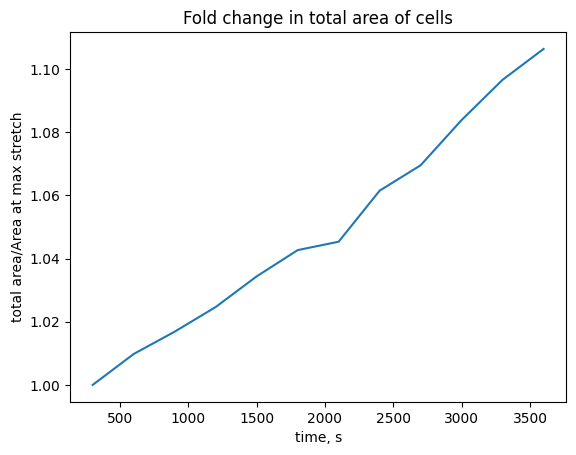

In [72]:

plt.plot(t[1:],np.array(areas_time.sum())[1:]/np.array(areas_time.sum())[1])
plt.xlabel("time, s")
plt.ylabel("total area/Area at max stretch")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area_max_stretch.png', dpi=300, bbox_inches='tight')

np.array(areas_time.sum())[1:]/np.array(areas_time.sum())[1]

In [81]:
indata_dir="C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Relaxation\\20230126\\Matrices"
R0  = np.loadtxt(glob(indata_dir+'/*_*'+'0p5'+'_'+'fr1'+'_*Matrix_R.txt')[0]) 
R300  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr1'+'_*Matrix_R.txt')[0]) 
R3600  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr56'+'_*Matrix_R.txt')[0]) 

R0=R0*(micron_size/pixel_size)
R300=R300*(micron_size/pixel_size)
R3600=R3600*(micron_size/pixel_size)

A0  = np.loadtxt(glob(indata_dir+'/*_*'+'0p5'+'_'+'fr1'+'_*Matrix_A.txt')[0]) 
A300  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr1'+'_*Matrix_A.txt')[0]) 
A3600  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr56'+'_*Matrix_A.txt')[0]) 



B0  = np.loadtxt(glob(indata_dir+'/*_*'+'0p5'+'_'+'fr1'+'_*Matrix_B.txt')[0]) 
B300  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr1'+'_*Matrix_B.txt')[0]) 
B3600  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr56'+'_*Matrix_B.txt')[0]) 

C0  = np.loadtxt(glob(indata_dir+'/*_*'+'0p5'+'_'+'fr1'+'_*Matrix_C.txt')[0]) 
C300  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr1'+'_*Matrix_C.txt')[0]) 
C3600  = np.loadtxt(glob(indata_dir+'/*_*'+'8p6'+'_'+'fr56'+'_*Matrix_C.txt')[0]) 

In [82]:
cec0=geometry.get_edge_count(B0)
cec300=geometry.get_edge_count(B300)
cec3600=geometry.get_edge_count(B3600)
cc0=geometry.get_cell_centres(C0, R0, cec0)
cc300=geometry.get_cell_centres(C300, R300, cec300)
cc3600=geometry.get_cell_centres(C3600, R3600, cec3600)

In [357]:
same_sides=np.where(cec0==cec300)[0]

<AxesSubplot: xlabel='time', ylabel='shape_parameter'>

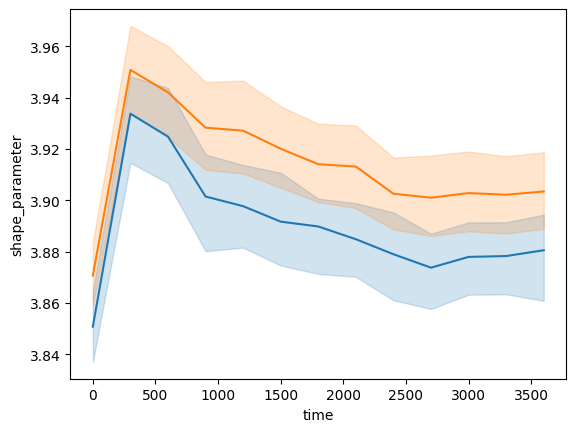

In [78]:
sns.lineplot(data=df, x='time', y='shape_parameter', estimator=np.median)
sns.lineplot(data=df, x='time', y='shape_parameter', estimator=np.mean)

In [358]:
cells0=[np.where(C0[x]==1)[0] for x in range(len(C0)) ]
cells300=[np.where(C300[x]==1)[0] for x in range(len(C300)) ]

In [448]:
strain_angle_R=np.zeros_like(cec0)
strain_angle_L=np.zeros_like(cec0)
maj_evals_R=np.zeros_like(cec0)
maj_evals_L=np.zeros_like(cec0)
min_evals_R=np.zeros_like(cec0)
min_evals_L=np.zeros_like(cec0)
shear_R=np.zeros_like(cec0)
shear_L=np.zeros_like(cec0)

trace_R=np.zeros_like(cec0)
trace_L=np.zeros_like(cec0)

det_F_L=np.zeros_like(cec0)
det_F_R=np.zeros_like(cec0)

strain_angle_R[:]=np.nan
strain_angle_L[:]=np.nan
maj_evals_R[:]=np.nan
maj_evals_L[:]=np.nan
min_evals_R[:]=np.nan
min_evals_L[:]=np.nan
shear_R[:]=np.nan
shear_L[:]=np.nan
trace_R[:]=np.nan
trace_L[:]=np.nan

det_F_L[:]=np.nan
det_F_R[:]=np.nan

for i in same_sides:
    R_ref=R0[cells0[i]]
    R_def=R300[cells300[i]]

    AT_RAN=cv2.estimateAffine2D(R_ref, R_def, method=cv2.RANSAC)[0]
    F_RAN=AT_RAN[:,:2]
    dR_RAN=AT_RAN[:, 2]
    

    AT_LMEDS=cv2.estimateAffine2D(R_ref, R_def, method=cv2.LMEDS)[0]
    F_LMEDS=AT_LMEDS[:,:2]
    dR_LMEDS=AT_LMEDS[:, 2]

    det_F_L[i]=np.linalg.det(F_LMEDS)
    det_F_R[i]=np.linalg.det(F_RAN)

    R_trans_R=(F_RAN@R_ref.T).T +dR_RAN
    R_trans_L=(F_LMEDS@R_ref.T).T +dR_LMEDS

    strain_RANSAC=0.5*(F_RAN+F_RAN.T)-np.eye(2)
    strain_LMEDS=0.5*(F_LMEDS+F_LMEDS.T)-np.eye(2)

    trace_R[i]=np.trace(strain_RANSAC)
    trace_L[i]=np.trace(strain_LMEDS)

    dev_strain_R=strain_RANSAC-0.5*np.trace(strain_RANSAC)*np.eye(2)
    dev_strain_L=strain_LMEDS-0.5*np.trace(strain_LMEDS)*np.eye(2)

    shear_R[i]=strain_RANSAC[0,1]
    shear_L[i]=strain_LMEDS[0,1]

    rot_RANSAC=0.5*(F_RAN-F_RAN.T)
    rot_LMEDS=0.5*(F_LMEDS-F_LMEDS.T)

    evals_R, evecs_R=np.linalg.eig(strain_RANSAC)
    if abs(evals_R[0])>abs(evals_R[1]):
        maj_eval_R=evals_R[0]
        min_eval_R=evals_R[1]
        maj_evec_R=evecs_R[0]
        min_evec_R=evecs_R[1]
    else:
        maj_eval_R=evals_R[1]
        min_eval_R=evals_R[0]
        maj_evec_R=evecs_R[1]
        min_evec_R=evecs_R[0]

    maj_strain_axis_R = np.arctan2(maj_evec_R[1]/(np.sqrt(maj_evec_R[0]**2+maj_evec_R[1]**2)),maj_evec_R[0]/(np.sqrt(maj_evec_R[0]**2+maj_evec_R[1]**2)))
    if maj_strain_axis_R<0:
        maj_strain_axis_R +=np.pi


    evals_L, evecs_L=np.linalg.eig(strain_LMEDS)

    if abs(evals_L[0])>abs(evals_L[1]):
        maj_eval_L=evals_L[0]
        min_eval_L=evals_L[1]
        maj_evec_L=evecs_L[0]
        min_evec_L=evecs_L[1]
    else:
        maj_eval_L=evals_L[1]
        min_eval_L=evals_L[0]
        maj_evec_L=evecs_L[1]
        min_evec_L=evecs_L[0]

    maj_strain_axis_L = np.arctan2(maj_evec_L[1]/(np.sqrt(maj_evec_L[0]**2+maj_evec_L[1]**2)),maj_evec_L[0]/(np.sqrt(maj_evec_L[0]**2+maj_evec_L[1]**2)))
    if maj_strain_axis_L<0:
        maj_strain_axis_L +=np.pi

    strain_angle_R[i]=maj_strain_axis_R
    strain_angle_L[i]=maj_strain_axis_L
    maj_evals_R[i]=maj_eval_R
    maj_evals_L[i]=maj_eval_L
    min_evals_R[i]=min_eval_R
    min_evals_L[i]=min_eval_L



(array([ 1.,  0.,  0.,  0.,  1.,  1.,  2.,  4.,  5., 12., 19., 38., 44.,
        37., 42., 29., 10., 10.,  5.,  5.,  3.,  0.,  1.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.44072948, -0.39966921, -0.35860894, -0.31754867, -0.2764884 ,
        -0.23542813, -0.19436786, -0.15330759, -0.11224731, -0.07118704,
        -0.03012677,  0.0109335 ,  0.05199377,  0.09305404,  0.13411431,
         0.17517458,  0.21623485,  0.25729512,  0.2983554 ,  0.33941567,
         0.38047594,  0.42153621,  0.46259648,  0.50365675,  0.54471702,
         0.58577729,  0.62683756,  0.66789784,  0.70895811,  0.75001838,
         0.79107865,  0.83213892,  0.87319919,  0.91425946,  0.95531973,
         0.99638   ,  1.03744027,  1.07850055,  1.11956082,  1.16062109,
         1.20168136,  1.24274163,  1.2838019 ,  1.32486217,  1.36592244,
         1.40698271,  1.44804298,  1.48910326,  1.53016353,

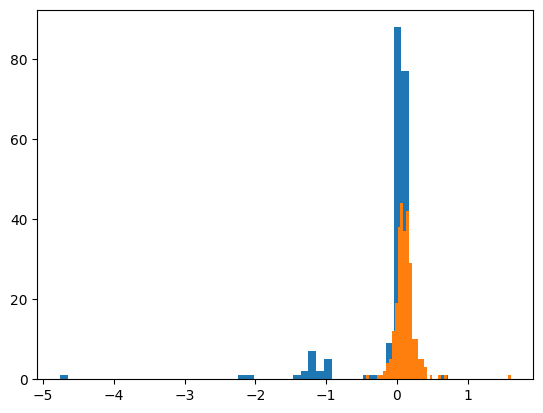

In [363]:
plt.hist(trace_R/2, bins=50)
plt.hist(frac_area_change, bins=50)

In [619]:
shear_strain_0=(df[df.time==0].cell_perimeter_microns/df[df.time==0].cell_area_microns)*df[df.time==0].cell_zeta
shear_strain_300=(df[df.time==300].cell_perimeter_microns/df[df.time==300].cell_area_microns)*df[df.time==300].cell_zeta

In [963]:
df[df.time==300].cell_area_microns

816      80.816706
817     177.445376
818     579.039985
819     380.219176
820     259.140524
           ...    
1083    889.276579
1084    994.982488
1085    815.487413
1086    905.527765
1087    944.179233
Name: cell_area_microns, Length: 272, dtype: float64

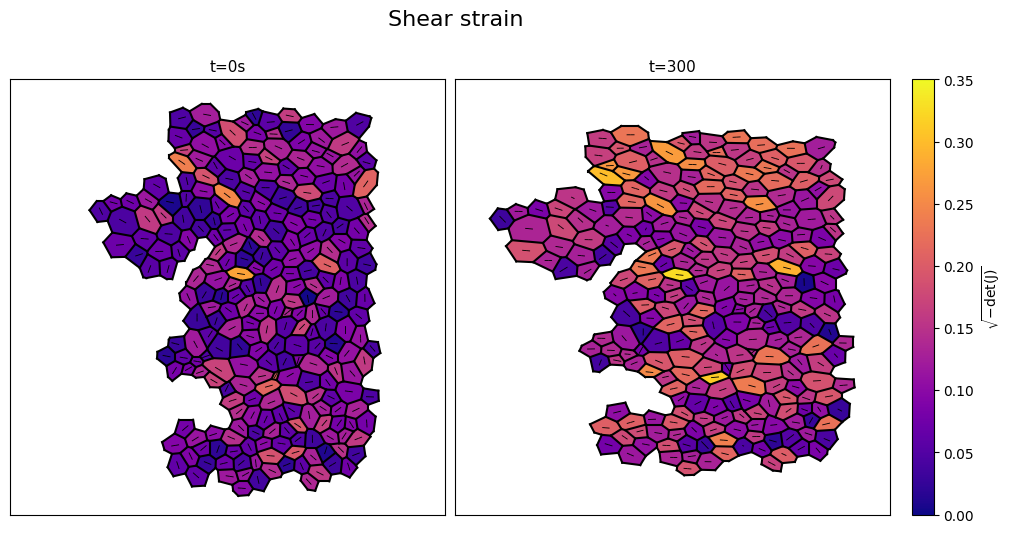

In [93]:
    R0=R0-np.mean(R0, axis=0)
    cc0=geometry.get_cell_centres(C0, R0, cec0)

    R300=R300-np.mean(R300, axis=0)
    cc300=geometry.get_cell_centres(C300, R300, cec300)

    R3600=R3600-np.mean(R3600, axis=0)
    cc3600=geometry.get_cell_centres(C3600, R3600, cec3600)
    #plot_variable=Area300/Area0 ###Set variable to plot

    fig, ax = plt.subplots(1,2,subplot_kw={'aspect': 'equal'}, layout='compressed')

    xlim=(-350, 250)
    ylim=(-300, 300)

    plt.setp(ax, xlim=xlim, ylim=ylim)

    # N_c=np.shape(C300)[0]

    # patches_out = []

    # for i in range(N_c):
    #     polygon = make_polygon(i, C300, R300, cc300)

        
    #     if np.isnan(plot_variable[i]):
    #         polygonLow = polygon
    #         patches_out.append(polygonLow)






    

    polys=plot_polys(C0, R0, cc0)
    #p_out.set_facecolor('grey')
    polys.set_array(np.array(df[df.time==0].cell_zeta))
    polys.set_cmap('plasma') ###set polygon colourmap here
    polys.set_clim(0, 0.35)
    ax[0].add_collection(polys) 

    polys=plot_polys(C300, R300, cc300)
    polys.set_array(np.array(df[df.time==300].cell_zeta))
    polys.set_cmap('plasma') ###set polygon colourmap here
    polys.set_clim(0, 0.35)
    ax[1].add_collection(polys) 
    #ax.add_collection(p_out) 




    ax[0].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax[0].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
    
    ax[1].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax[1].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

    N_e=np.shape(A0)[0]
    beg_edge = ((abs(A0) - A0)*0.5)@R0
    end_edge = ((abs(A0) + A0)*0.5)@R0
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            ax[0].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')

    N_e=np.shape(A300)[0]
    beg_edge = ((abs(A300) - A300)*0.5)@R300
    end_edge = ((abs(A300) + A300)*0.5)@R300
    for j in range(0,N_e):
        if (beg_edge[j,0]!=0) and (end_edge[j, 0]!=0):
            ax[1].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],'k',alpha=1.0,linestyle ='-')
    
    #plot_alignment_axis(cc300,strain_angle_R)
    #plot_alignment_axis(cc3600,np.asarray(df[df.time==3600].major_shape_axis_alignment_rads))
    for i in range(len(cc0)):
        ax[0].quiver(cc0[i,0],cc0[i,1],np.cos(np.asarray(df[df.time==0].major_shape_axis_alignment_rads))[i],np.sin(np.asarray(df[df.time==0].major_shape_axis_alignment_rads))[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
        ax[0].quiver(cc0[i,0],cc0[i,1],-np.cos(np.asarray(df[df.time==0].major_shape_axis_alignment_rads))[i],-np.sin(np.asarray(df[df.time==0].major_shape_axis_alignment_rads))[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
    for i in range(len(cc3600)):
        ax[1].quiver(cc300[i,0],cc300[i,1],np.cos(np.asarray(df[df.time==3600].major_shape_axis_alignment_rads))[i],np.sin(np.asarray(df[df.time==300].major_shape_axis_alignment_rads))[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
        ax[1].quiver(cc300[i,0],cc300[i,1],-np.cos(np.asarray(df[df.time==3600].major_shape_axis_alignment_rads))[i],-np.sin(np.asarray(df[df.time==300].major_shape_axis_alignment_rads))[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)

    #ax.set_title('Area/Initial Area, t=300s') ###change title
    ax[0].set_xlim([-350, 250])
    ax[0].set_ylim([-300, 300])
    ax[1].set_xlim([-350, 250])
    ax[1].set_ylim([-300, 300])
    #plt.subplots_adjust(wspace=-0.05, hspace=None)
    ax[0].set_title("t=0s", fontsize=11)
    ax[1].set_title("t=300", fontsize=11)
    #cbar = fig.colorbar(polys, extend='both', shrink=0.6)
    #cbar.ax.set_ylabel('Area/Initial Area', rotation=90) ###set colorbar label
    #plt.gca().set_aspect('equal')
    plt.suptitle("Shear strain", fontsize=16, x=0.45, y=0.97)
    #plt.figure(figsize=(10,6))
    #cbar=fig.colorbar(polys, ax=ax.ravel().tolist(), extend='both', shrink=0.5)
    cbar = fig.colorbar(polys,ax=ax[1])
    cbar.ax.set_ylabel('$\sqrt{-\mathrm{det}(\mathsf{J})}$', rotation=90) ###set colorbar label
    fig.set_size_inches(10,6)

    #plt.tight_layout()

    ##uncomment to save
    fig.savefig(plot_dir+'20230126_zeta_0_300_relax.png', dpi=300, bbox_inches='tight')

In [90]:
np.max(df.cell_zeta)

0.3450020752552237

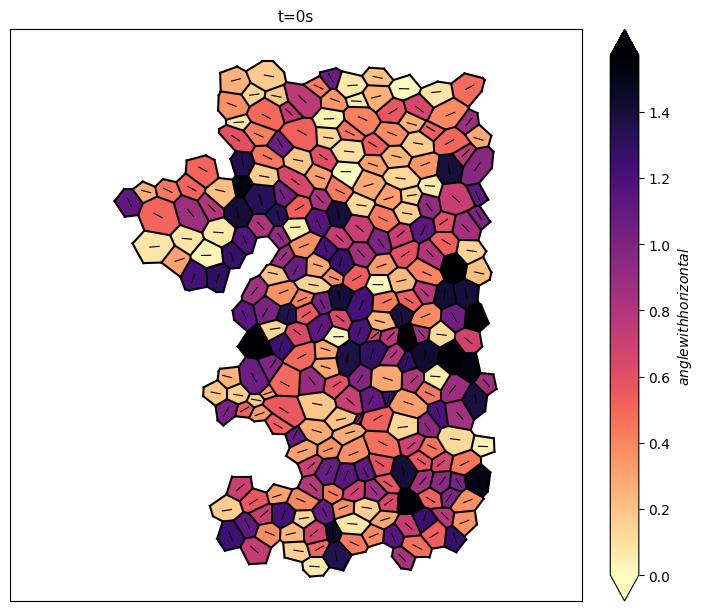

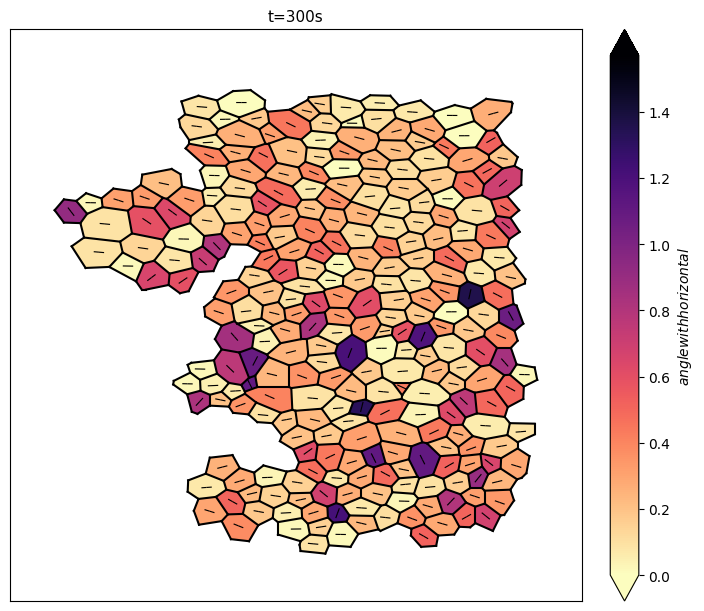

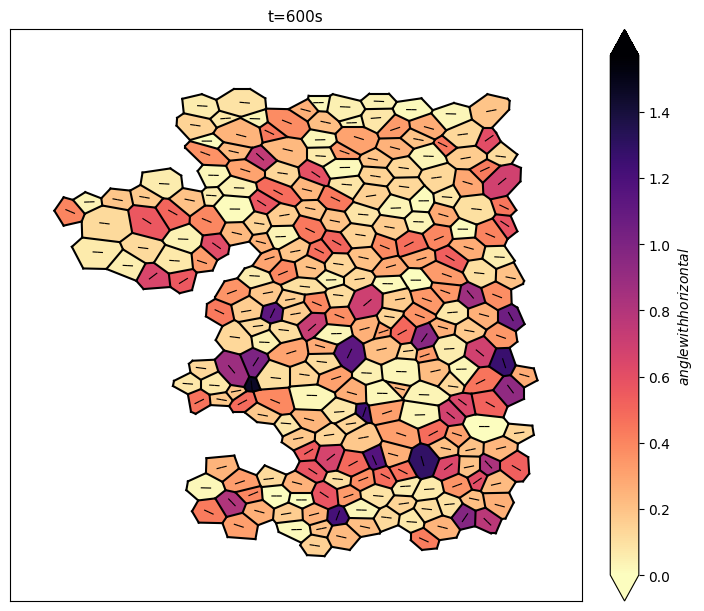

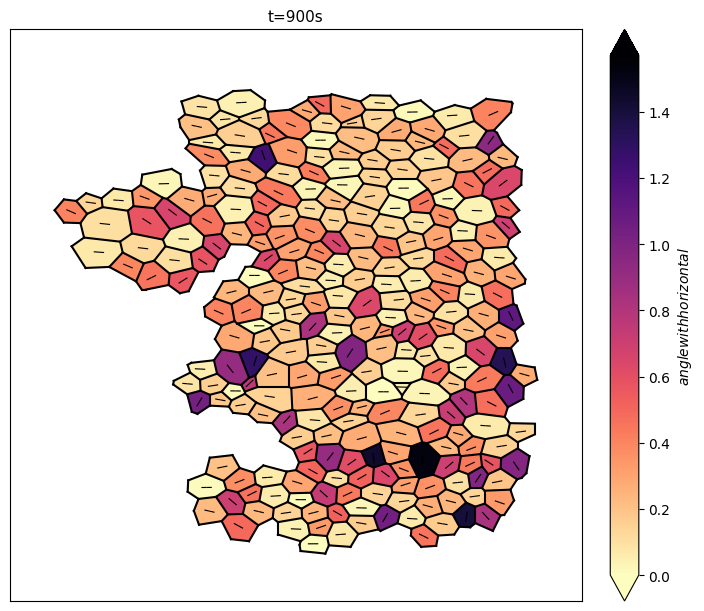

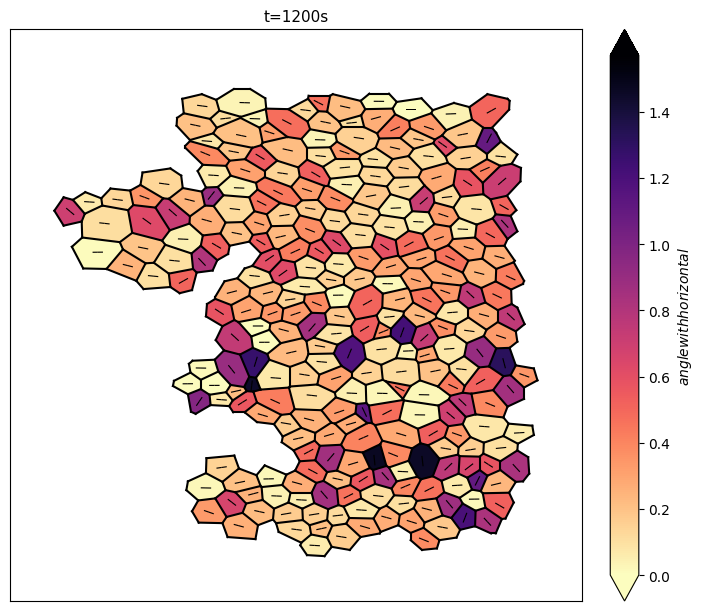

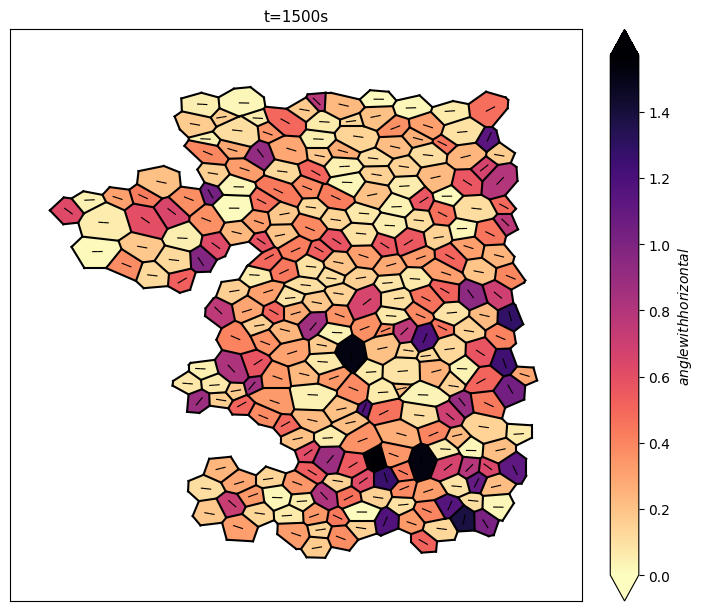

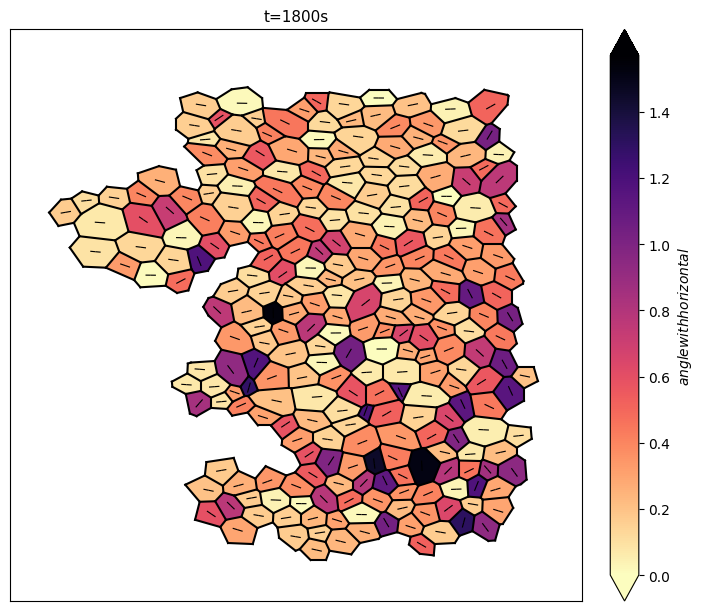

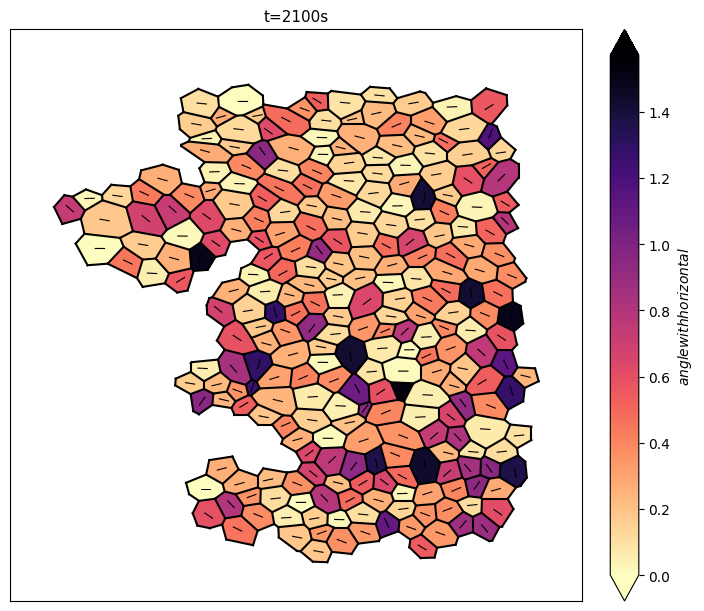

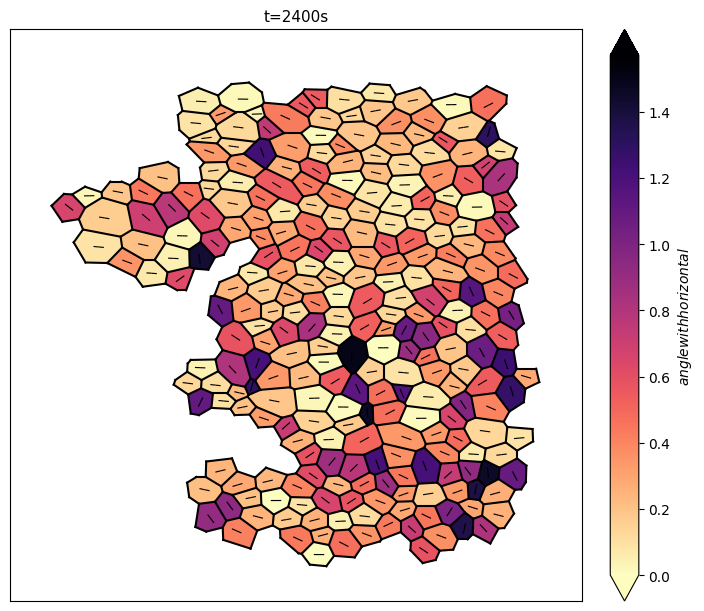

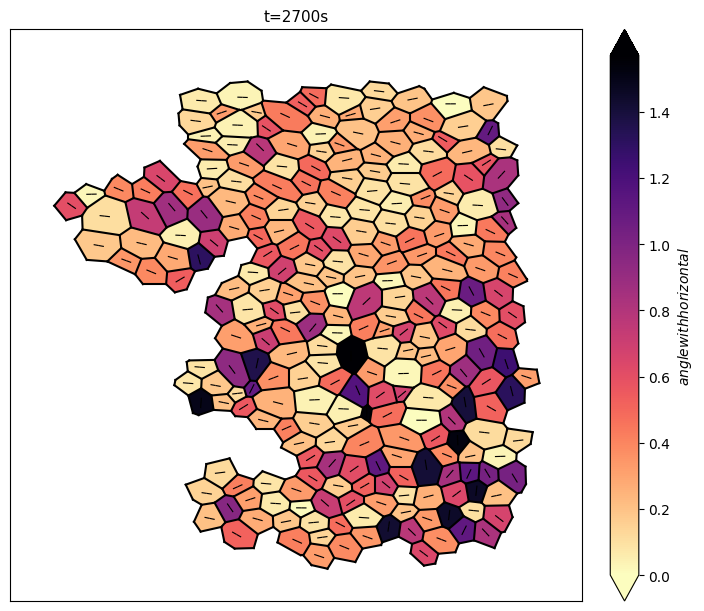

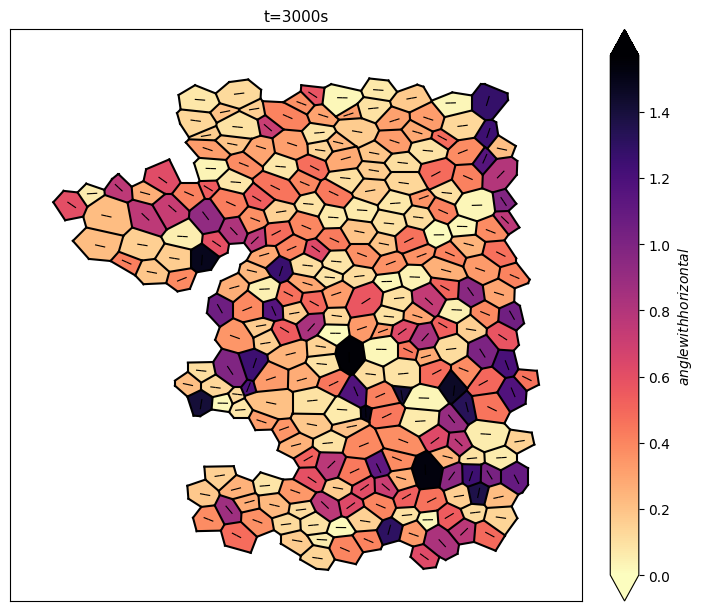

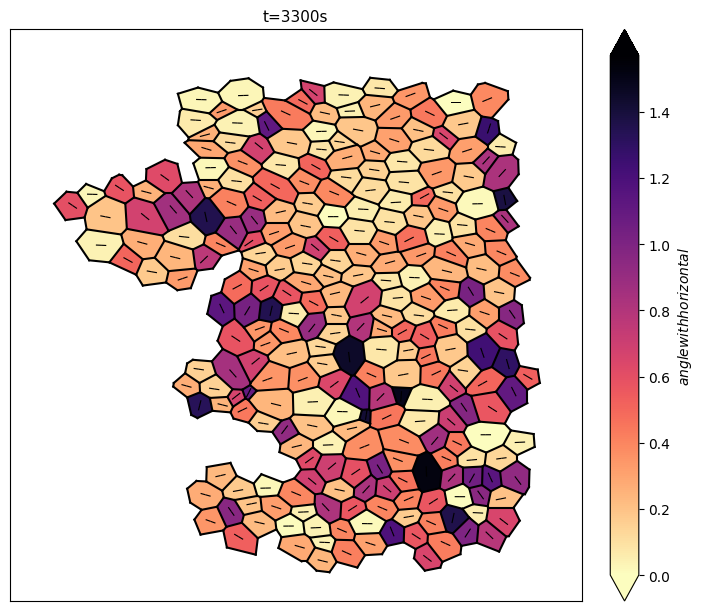

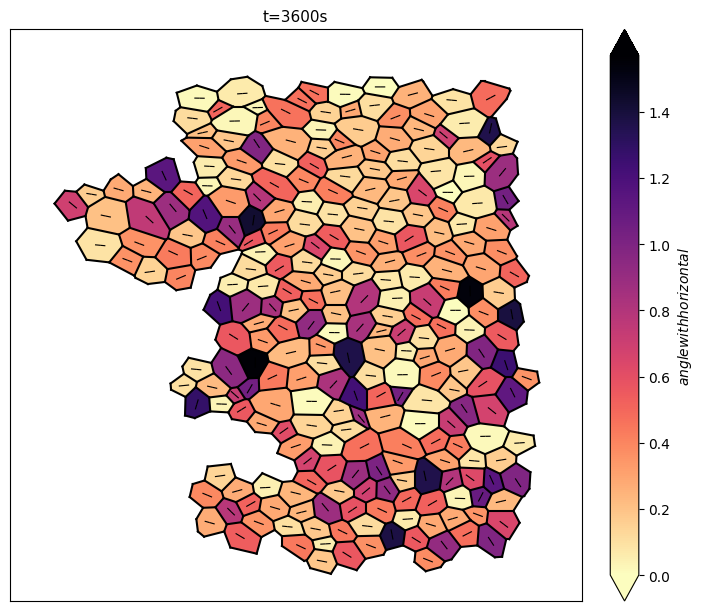

In [51]:
t=np.unique(df.time)
for i in range(len(R_all)):
    R=R_all[i]-np.mean(R_all[i], axis=0)
    
    C=C_all[i]
    A=A_all[i]
    cec=geometry.get_edge_count(B_all[i])
    cc=geometry.get_cell_centres(C, R, cec)


    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'}, layout='compressed')

    xlim=(-350, 250)
    ylim=(-300, 300)

    plt.setp(ax, xlim=xlim, ylim=ylim)

    # N_c=np.shape(C300)[0]

    # patches_out = []

    # for i in range(N_c):
    #     polygon = make_polygon(i, C300, R300, cc300)

        
    #     if np.isnan(plot_variable[i]):
    #         polygonLow = polygon
    #         patches_out.append(polygonLow)






    

    polys=plot_polys(C, R, cc)
    #p_out.set_facecolor('grey')
    polys.set_array(np.array(df[df.time==t[i]].angle_horizontal))
    polys.set_cmap('magma_r') ###set polygon colourmap here
    polys.set_clim(0, np.pi/2)
    ax.add_collection(polys) 




    plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
    
    plot_edges(A,R)
    
    #plot_alignment_axis(cc300,strain_angle_R)
    plot_alignment_axis(cc,np.asarray(df[df.time==t[i]].major_shape_axis_alignment_rads))

    #ax.set_title('Area/Initial Area, t=300s') ###change title
    plt.xlim([-350, 250])
    plt.ylim([-300, 300])

    #plt.subplots_adjust(wspace=-0.05, hspace=None)
    plt.title("t="+str(t[i])+'s', fontsize=11)
    cbar = fig.colorbar(polys, ax=ax)
    cbar.ax.set_ylabel('$angle with horizontal$', rotation=90) ###set colorbar label
    plt.gca().set_aspect('equal')
  
    #plt.figure(figsize=(10,6))

    fig.set_size_inches(10,6)

    #plt.tight_layout()

    ##uncomment to save
    fig.savefig(plot_dir+'angle_horizontal_t_'+str(t[i])+'.png', dpi=300, bbox_inches='tight')

(0.5, 2.0)

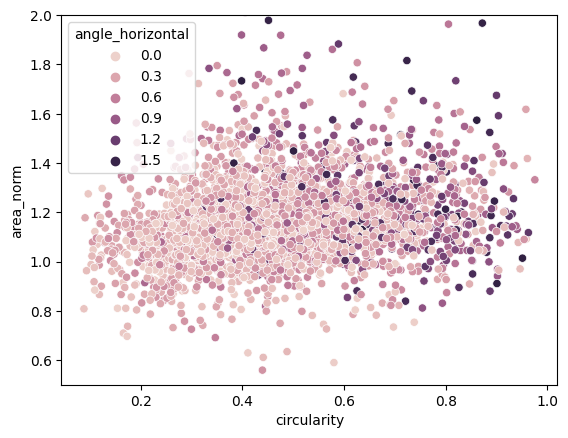

In [65]:
sns.scatterplot(data=df[df.time!=0], hue='angle_horizontal', y='area_norm', x='circularity')
plt.ylim(0.5, 2)

In [349]:
Area0=np.asarray(df[df.time==0].cell_area_microns)
Area300=np.asarray(df[df.time==300].cell_area_microns)

frac_area_change=(Area300-Area0)/Area0

In [425]:
Rsq=np.zeros(len(cc0))
slope=np.zeros(len(cc0))
intercept=np.zeros(len(cc0))
for i in range(len(cc0)):
    res = linregress(t,df[df.cell_id==i].sort_values(by=['time']).cell_area_microns)
    Rsq[i]=res.rvalue**2
    slope[i]=res.slope
    intercept[i]=res.intercept



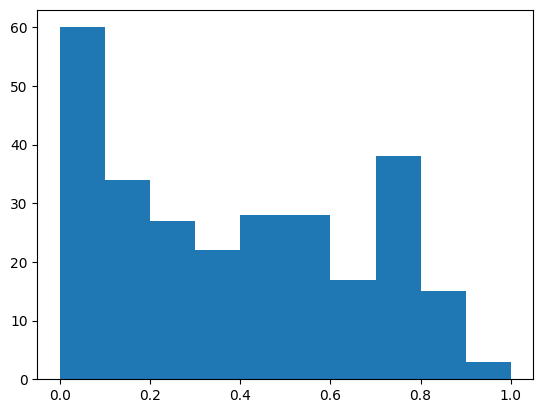

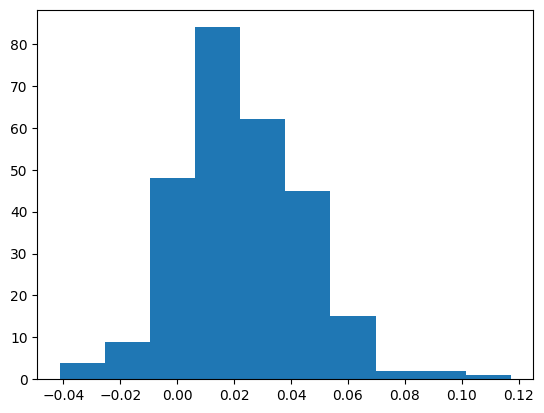

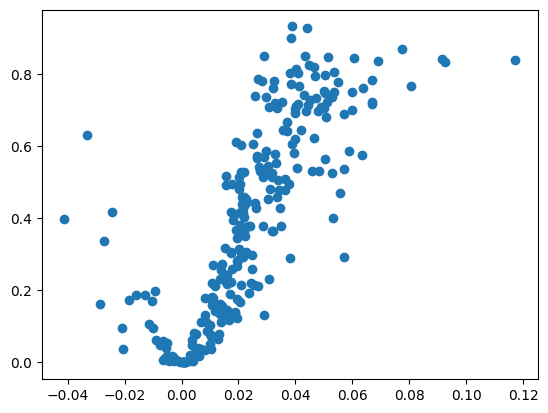

In [432]:
plt.hist(Rsq, range=[0,1], bins=10)
plt.show()
plt.hist(slope, bins=10)
plt.show()
plt.scatter(slope, Rsq)

In [433]:
def monotonic(x):
    dx = np.diff(x)
    return np.all(dx <= 0) or np.all(dx >= 0)


In [446]:
is_monotonic=np.zeros(len(cc0))
for i in range(len(cc0)):
    is_monotonic[i]=monotonic(df[df.cell_id==i].sort_values(by=['time']).cell_area_microns)
np.where(is_monotonic==True)

(array([], dtype=int64),)

In [372]:
print(cv2.estimateAffine2D(R0[cells0[same_sides[0]]], R300[cells300[same_sides[0]]], method=cv2.RANSAC))
print(cv2.estimateAffine2D(R0[cells0[same_sides[0]]], R300[cells300[same_sides[0]]], method=cv2.LMEDS))

(array([[ 1.23894376, -0.1474951 , 10.53226776],
       [-0.08795654,  0.98755521, 32.77444997]]), array([[1],
       [1],
       [1],
       [1]], dtype=uint8))
(array([[ 1.24999963, -0.16666658, 11.81462503],
       [-0.07237063,  0.96052837, 34.58224176]]), array([[1],
       [1],
       [1],
       [0]], dtype=uint8))


In [199]:
print(cv2.estimateAffine2D(R0[cells0[same_sides[-1]]], R300[cells300[same_sides[-1]]], method=cv2.RANSAC))
print(cv2.estimateAffine2D(R0[cells0[same_sides[-1]]], R300[cells300[same_sides[-1]]], method=cv2.LMEDS))

(array([[ 1.24544548e+00,  4.43936477e-02, -1.08404871e+02],
       [ 6.06695999e-03,  1.00910330e+00, -5.94804929e+01]]), array([[1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0]], dtype=uint8))
(array([[ 1.25952817e+00, -8.19553884e-02,  1.94901643e+00],
       [-7.69743504e-03,  8.27751785e-01,  1.11448009e+02]]), array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1]], dtype=uint8))


[[ 0.56109736 -0.37406491]
 [-0.37406491  0.07730672]]
[[ 0.45833332  0.02517359]
 [ 0.02517359 -0.25173616]]


[[ 0.         -0.08229431]
 [ 0.08229431  0.        ]]
[[ 0.         0.3168403]
 [-0.3168403  0.       ]]


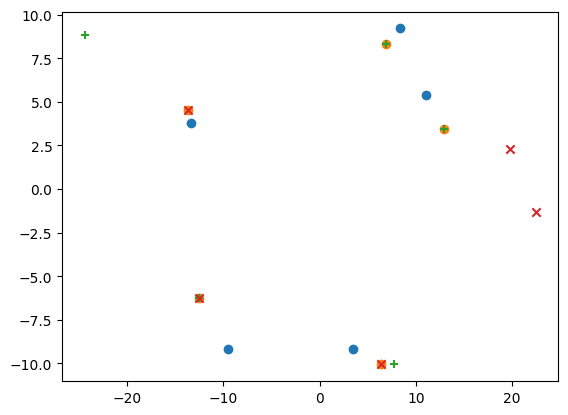

In [527]:
R_def=R300[cells300[8]]-np.mean(R300[cells300[8]], axis=0)
R_ref=R0[cells0[8]]-np.mean(R0[cells0[8]], axis=0)

AT_RAN=cv2.estimateAffine2D(R_ref, R_def_sort, method=cv2.RANSAC, confidence=0.999999, refineIters=0)[0]
F_RAN=AT_RAN[:,:2]
dR_RAN=AT_RAN[:, 2]


AT_LMEDS=cv2.estimateAffine2D(R_ref, R_def_sort, method=cv2.LMEDS,confidence=0.999999,refineIters=0)[0]
F_LMEDS=AT_LMEDS[:,:2]
dR_LMEDS=AT_LMEDS[:, 2]

R_trans_R=(F_RAN@R_ref.T).T +dR_RAN
R_trans_L=(F_LMEDS@R_ref.T).T +dR_LMEDS

strain_RANSAC=0.5*(F_RAN+F_RAN.T)-np.eye(2)
strain_LMEDS=0.5*(F_LMEDS+F_LMEDS.T)-np.eye(2)

rot_RANSAC=0.5*(F_RAN-F_RAN.T)
rot_LMEDS=0.5*(F_LMEDS-F_LMEDS.T)

print(strain_RANSAC)
print(strain_LMEDS)
print('\n')
print(rot_RANSAC)
print(rot_LMEDS)



plt.scatter((R_ref)[:,0], (R_ref)[:,1])
plt.scatter(R_def_sort[:,0], R_def_sort[:,1])
plt.scatter(R_trans_R[:,0], R_trans_R[:,1], marker='+')
plt.scatter(R_trans_L[:,0], R_trans_L[:,1], marker='x')


In [528]:

print(cdist(R_ref,R_def))

R_def_sort=np.array([R_def[1], R_def[0], R_def[3], R_def[2], R_def[4]])

print(R_ref)
print(R_def_sort)


[[15.93255926  4.20964517 25.73334531 14.34659972 24.04145816]
 [ 3.04763267 16.28160029 15.77928166 21.9386526  17.87115698]
 [24.08040118 10.09335919 26.19236783  0.82421407 20.74217177]
 [16.16065588 26.32951501  2.67951544 24.69039568  5.04493866]
 [19.3622265  25.99599272  7.31857668 22.45706281  1.65197697]]
[[ -9.52376563  -9.1990918 ]
 [  3.4631875   -9.1990918 ]
 [-13.31162695   3.78786133]
 [ 11.03891016   5.41123047]
 [  8.33329492   9.1990918 ]]
[[-12.55405469  -6.27702734]
 [  6.38525195 -10.06488867]
 [-13.63630078   4.54543359]
 [ 12.87872852   3.4631875 ]
 [  6.926375     8.33329492]]


In [251]:
np.sort(np.linalg.eig(strain_RANSAC), axis=0)
#np.linalg.eig(strain_LMEDS)

C:\Users\v35431nc\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:1003: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a).copy(order="K")


ValueError: could not broadcast input array from shape (2,2) into shape (2,)

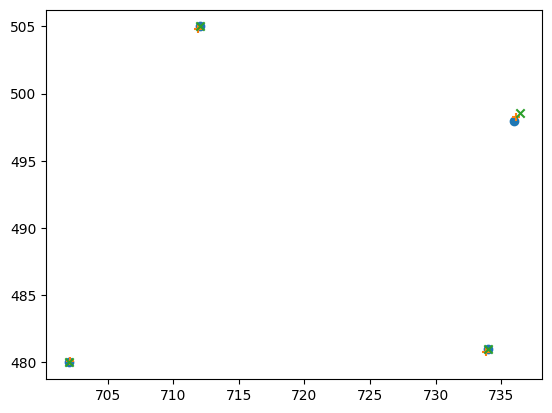

In [221]:
Fp1=np.array([[ 1.23894366, -0.14749438],
       [-0.08795536,  0.98755492]] )
ds1= np.array([19.46343338, 60.56687037])

Fp2=np.array([[ 1.24727838, -0.14307932],
       [-0.07620529,  0.99377916 ]])
ds2= np.array([12.18973561, 50.3125972])

R_new1=np.zeros_like(R0[cells0[same_sides[0]]])
R_new2=np.zeros_like(R0[cells0[same_sides[0]]])
for i in range(4):
    R_new1[i]=Fp1@(R0[cells0[same_sides[0]]][i])
    R_new2[i]=Fp2@(R0[cells0[same_sides[0]]][i])

plt.scatter(R300[cells300[same_sides[0]]][:,0], R300[cells300[same_sides[0]]][:,1])
plt.scatter((R_new1+ds1)[:,0], (R_new1+ds1)[:,1], marker='+')
plt.scatter((R_new2+ds2)[:,0], (R_new2+ds2)[:,1], marker='x')

In [234]:
(Fp1@(R0[cells0[same_sides[0]]].T)).T +ds1

array([[702.09137064, 480.12881817],
       [733.86142266, 480.80464357],
       [736.16229846, 498.22881069],
       [711.88489702, 504.83773713]])

In [233]:
R300[cells300[same_sides[0]]]

array([[702., 480.],
       [734., 481.],
       [736., 498.],
       [712., 505.]])

In [242]:
R_def

array([[683., 830.],
       [706., 835.],
       [717., 857.],
       [635., 858.],
       [709., 871.],
       [632., 873.],
       [690., 879.],
       [644., 883.]])